# Data

- 실험을 위한 데이터취득 (Myo를 이용한 sEMG 데이터)
- 5회에 걸쳐 쎄게 주먹을 쥐고, 폈다를 반복한 데이터.
- 200Hz의 Sampling rate


In [1]:
import warnings
import math
import collections
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# emg file directory & path

emg_rock_short_path = "./myo/myo_emg_data(short_frequently_lock).txt"

In [3]:
# load Strongly Short Power emg data

sensor_channels = 8
short_emgs = [list() for i in range(sensor_channels)]

with open(emg_rock_short_path) as f:
    while(1):                
        line = f.readline().rstrip()
        line = line.replace(" ", "")
        if (line is None or line == ""):
            break
        
        #print(line)        
        _emgs = line.split("\t")                
        
        for i in range(sensor_channels):
            short_emgs[i].append(int(_emgs[i]))            

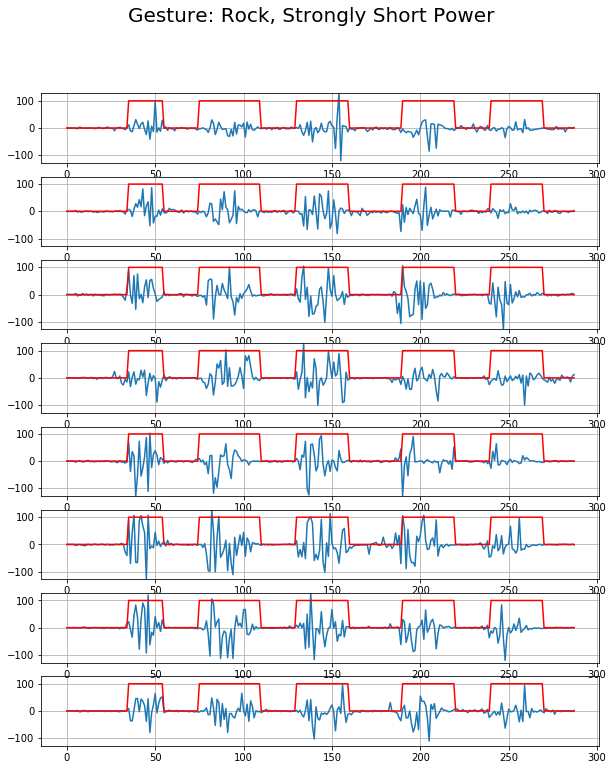

In [4]:
fig = plt.figure(figsize=(10,12))
fig.suptitle("Gesture: Rock, Strongly Short Power", fontsize=20)

# manually annotation
label = np.zeros(len(short_emgs[0]))
label[35:55] = 1
label[75:110] = 1
label[130:160] = 1
label[190:220] = 1
label[240:270] = 1

for i in range(sensor_channels):
    arg = "81" + str(i)
    plt.subplot(arg)
    plt.plot(short_emgs[i])
    plt.plot(label*100, color='red')
    plt.grid()
    plt.ylim([-128, 127])

plt.show()

number of sliced sEMG : 9


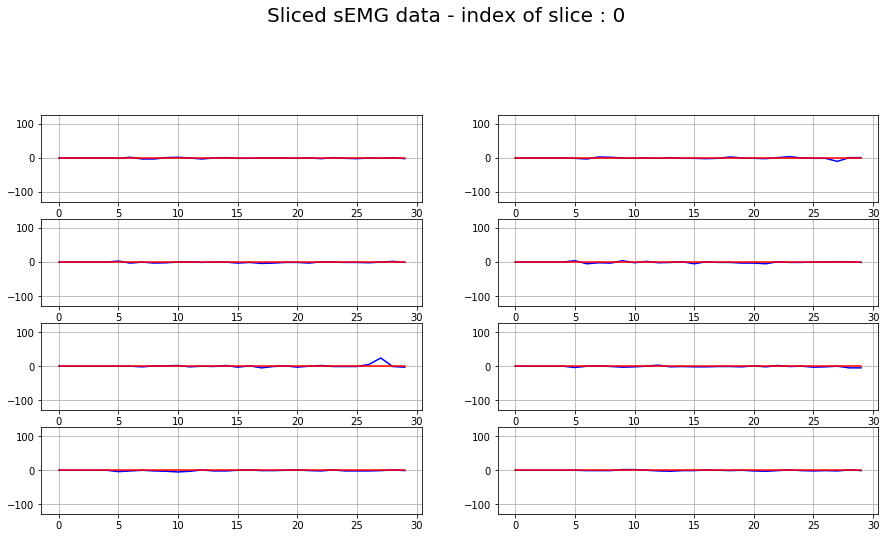

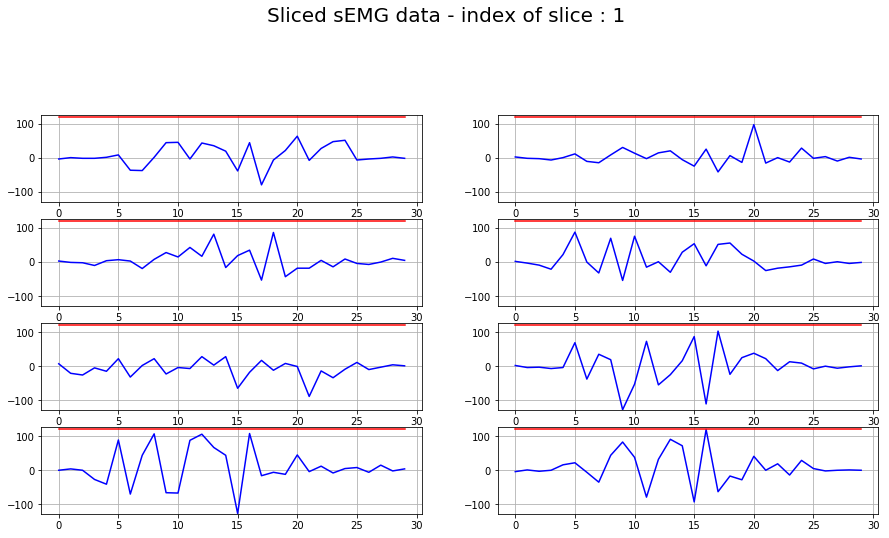

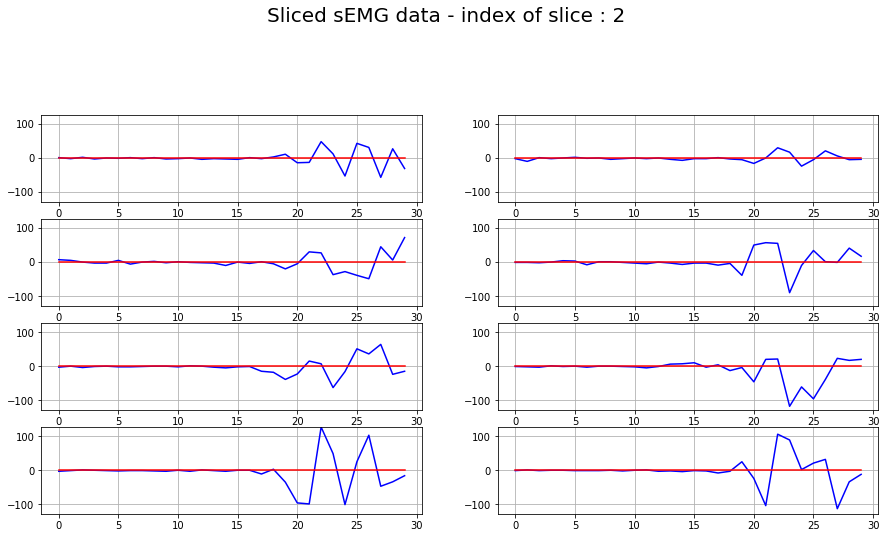

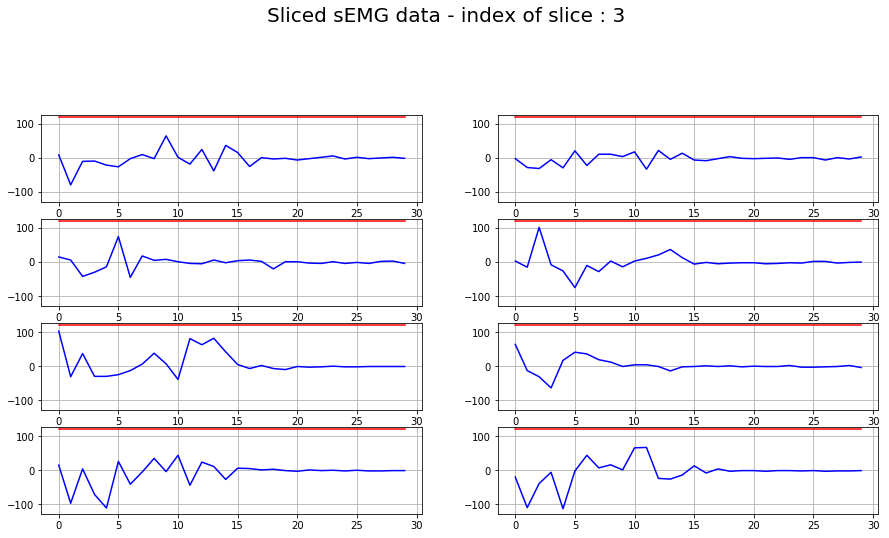

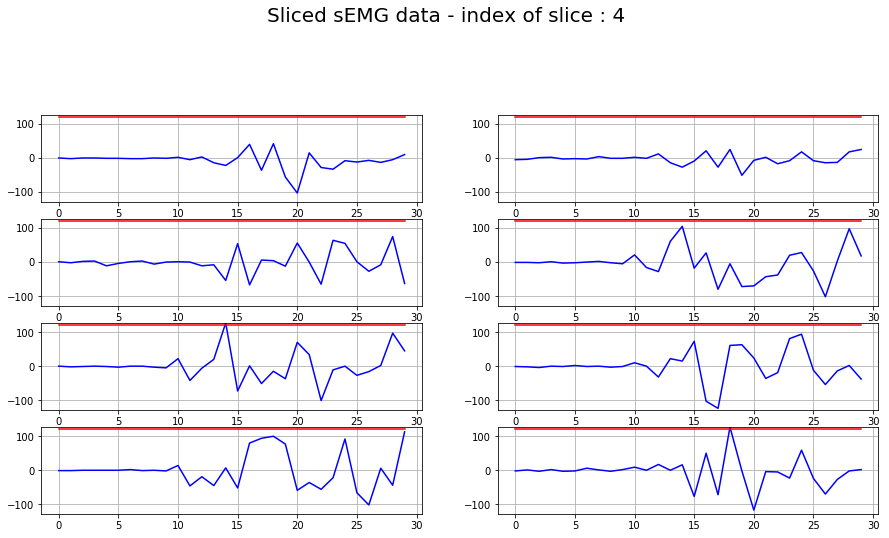

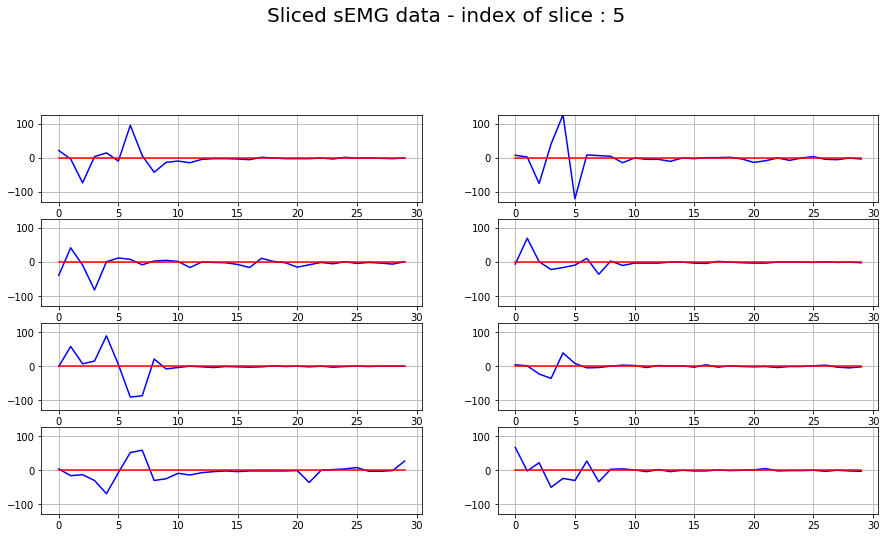

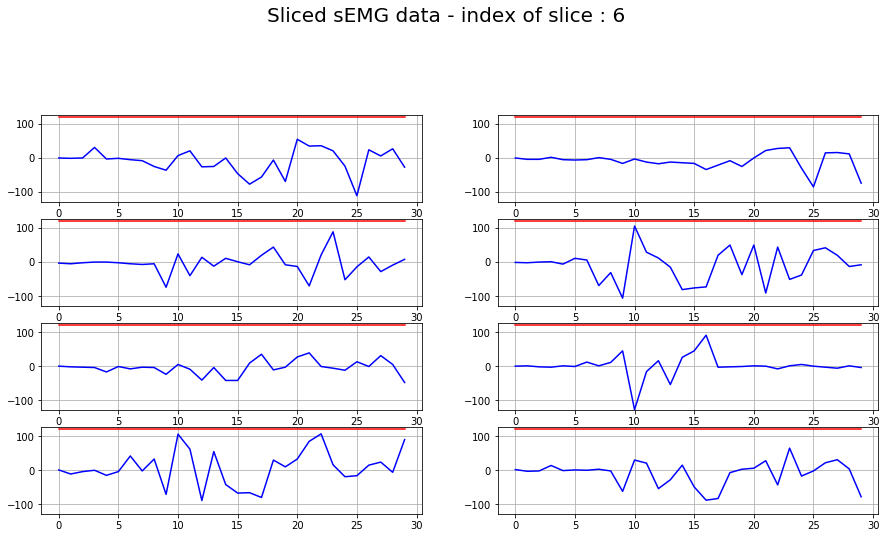

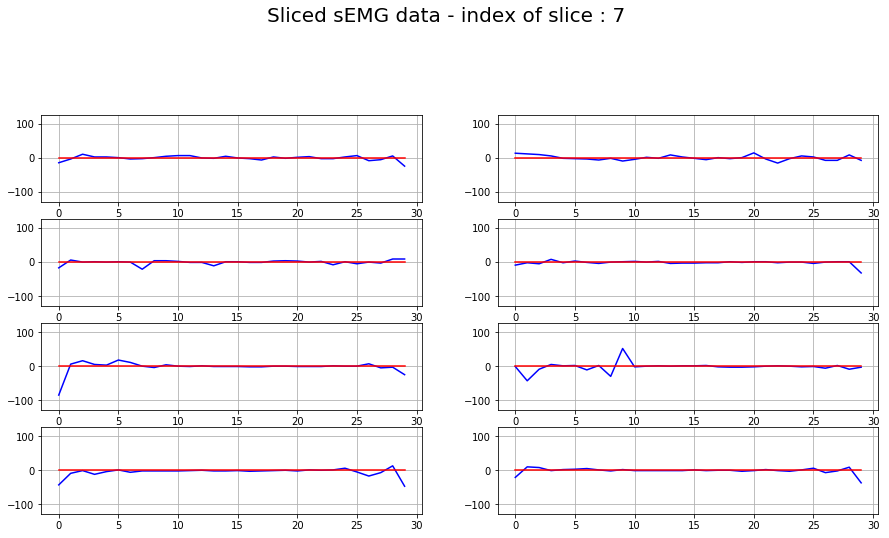

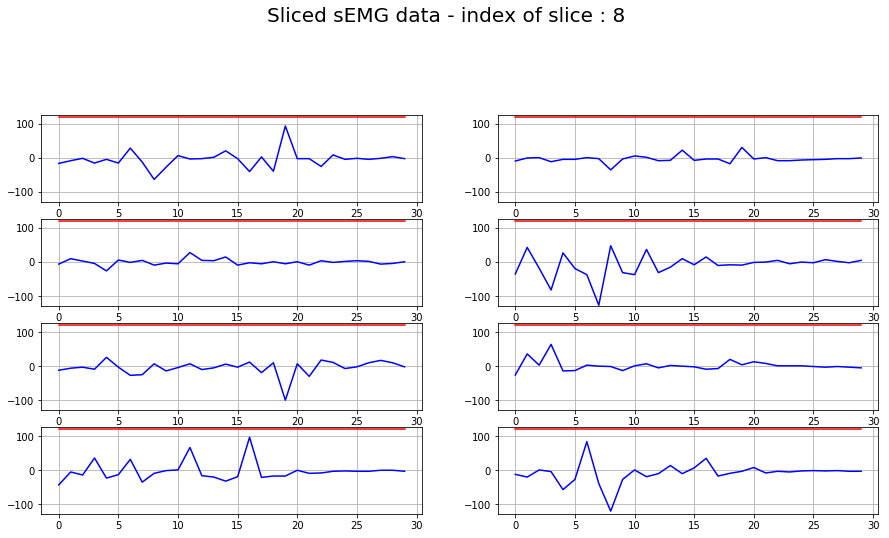

In [5]:
# sEMG slicing. interval is 30 points
interval = 30

sEMGs = [list() for i in range(sensor_channels)]
yhats = [list() for i in range(sensor_channels)]


num_slicedEMG = len(short_emgs[0]) // 30

print("number of sliced sEMG : {}".format(num_slicedEMG))

# slicing
for i in range(sensor_channels):
    idx = 0
    for j in range(num_slicedEMG):
        sEMGs[i].append(short_emgs[i][idx : idx + interval])
        yhats[i].append(label[idx : idx + interval])
        idx += interval

# label of segment is contraction when contraction ratio more than .7
num_yhat = interval * .5
for i in range(sensor_channels):
    idx = 0
    for j in range(num_slicedEMG):
        counts_info = collections.Counter(yhats[i][j])
        yhat_counts = counts_info[1.0]
        if yhat_counts > num_yhat:
            yhats[i][j] = np.ones((yhats[i][j].size))
        else:
            yhats[i][j] = np.zeros((yhats[i][j].size))
    
for i in range(num_slicedEMG):
    
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle("Sliced sEMG data - index of slice : {}".format(str(i)), fontsize=20)
    
    for j in range(sensor_channels):
        arg = "{}2".format(str(sensor_channels)) + str(j+1)
        plt.subplot(arg)
        plt.plot(sEMGs[j][i], color='blue')
        plt.plot(yhats[j][i] * 120, color='red')
        plt.ylim([-128, 127])
        plt.grid()

    plt.show()

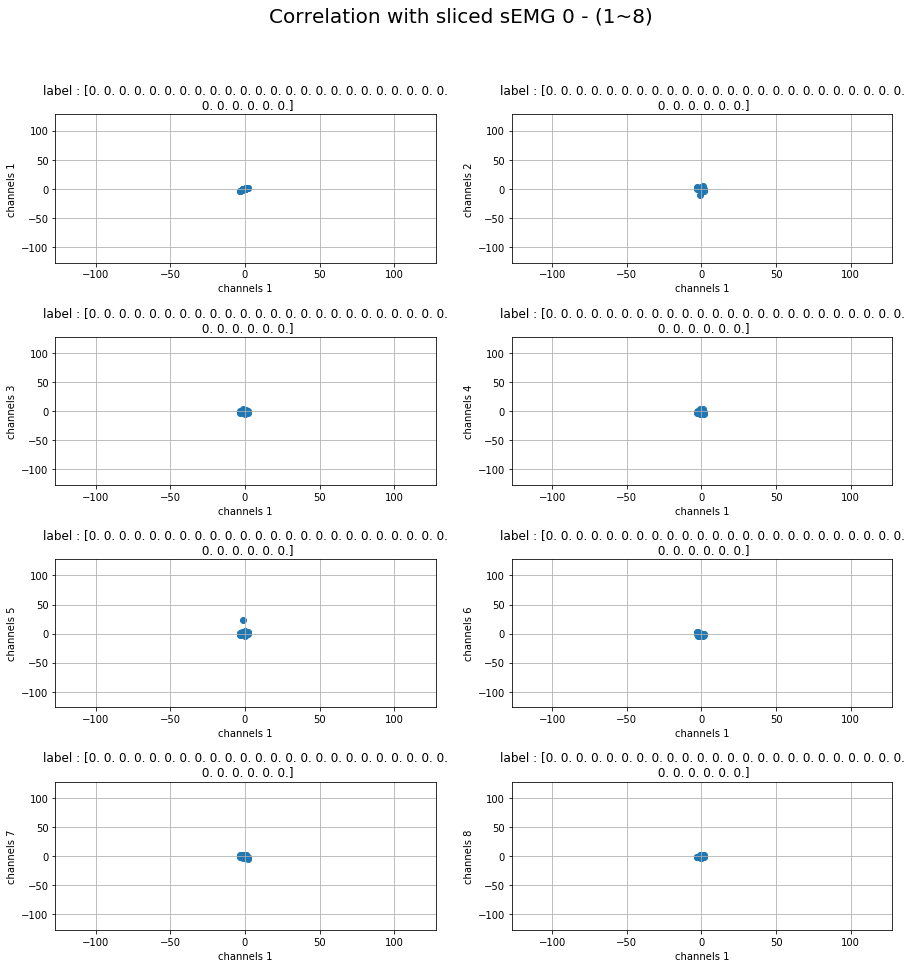

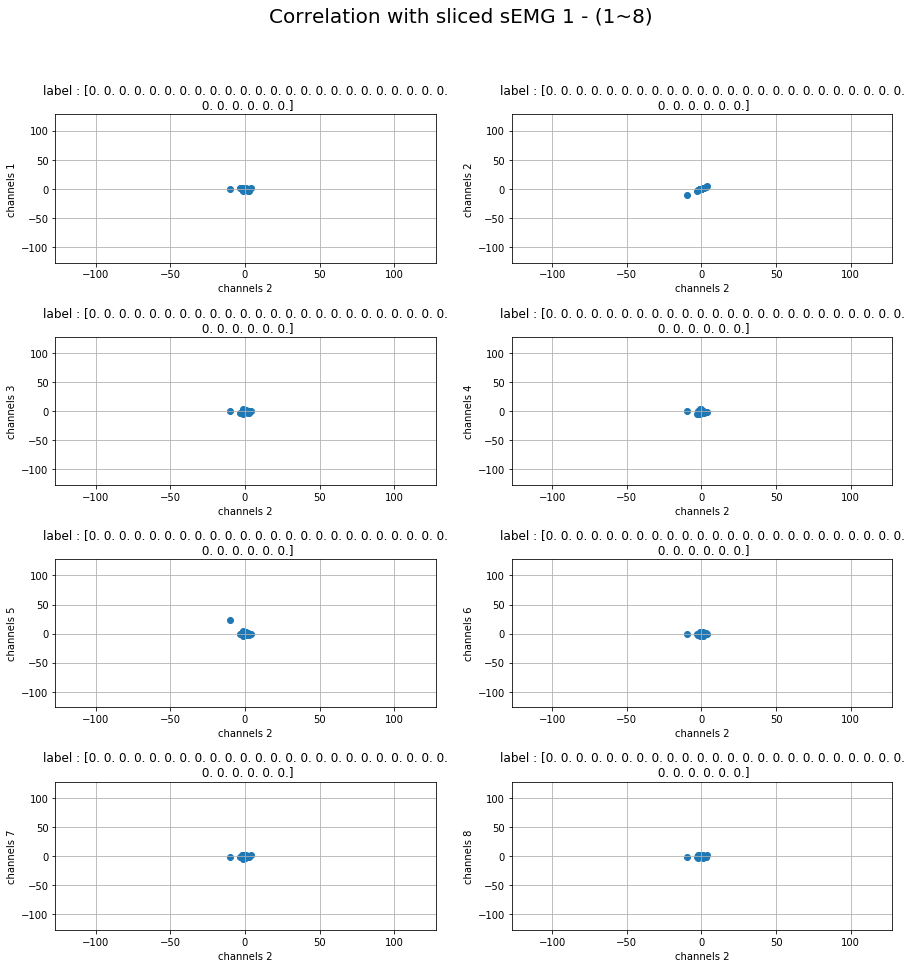

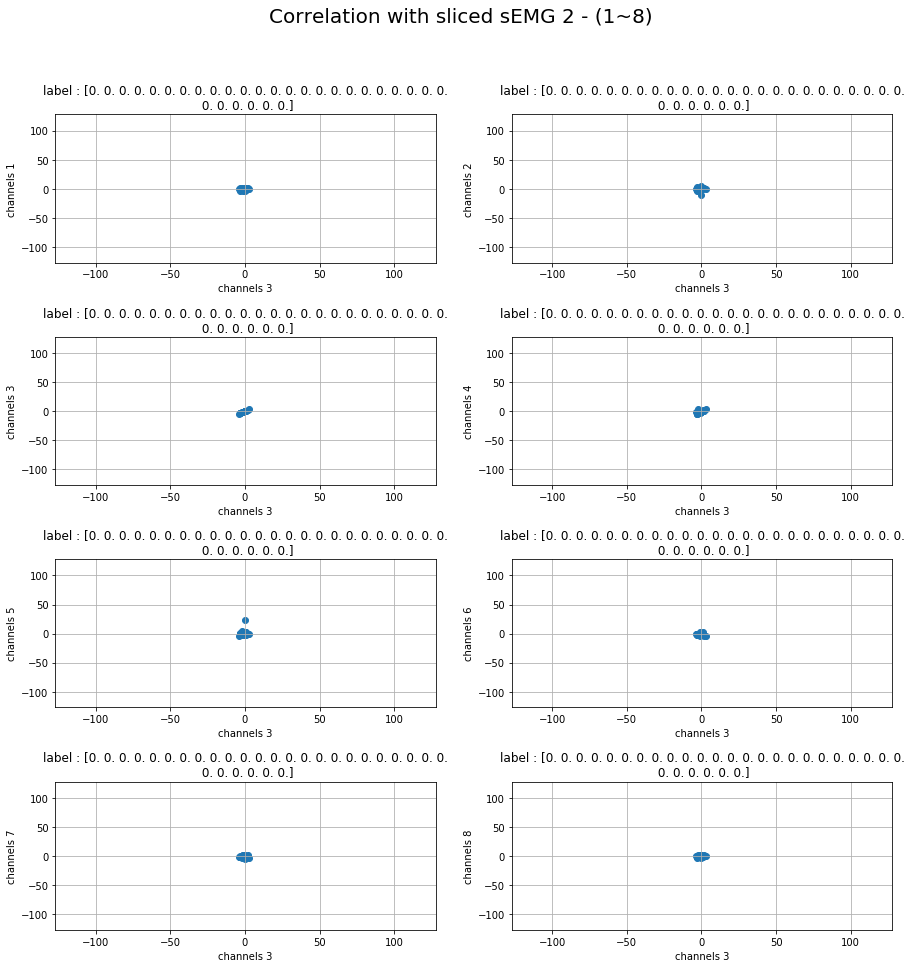

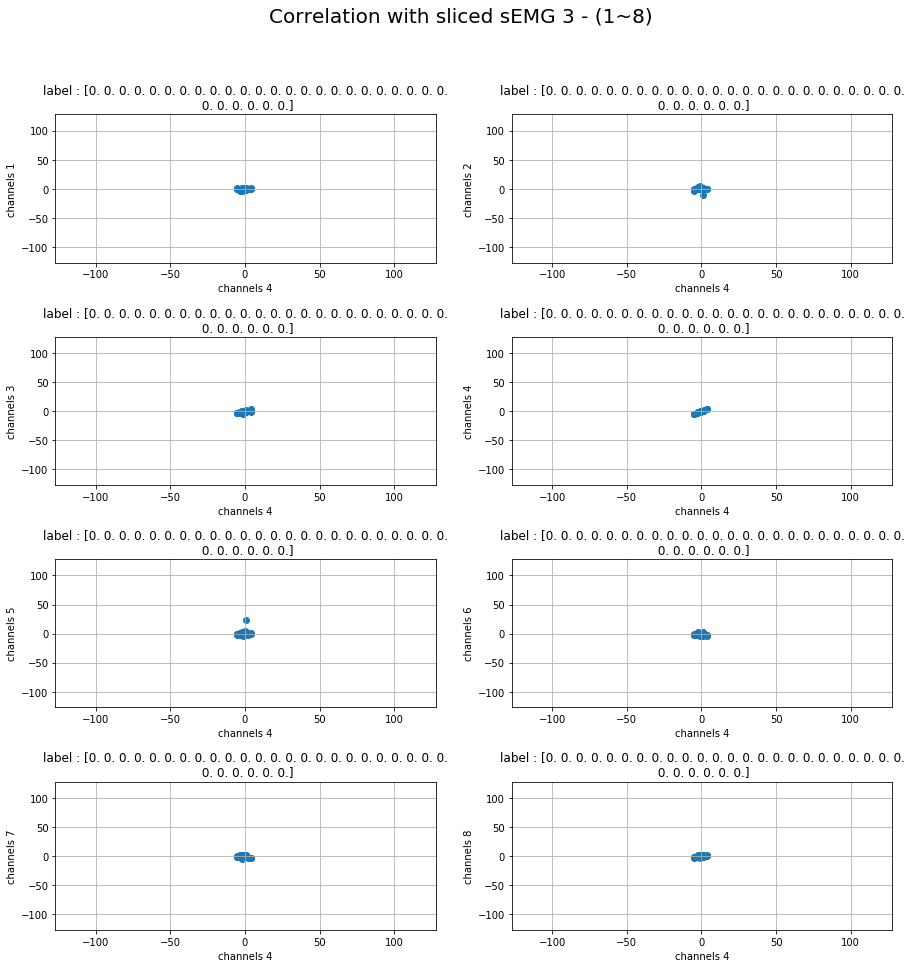

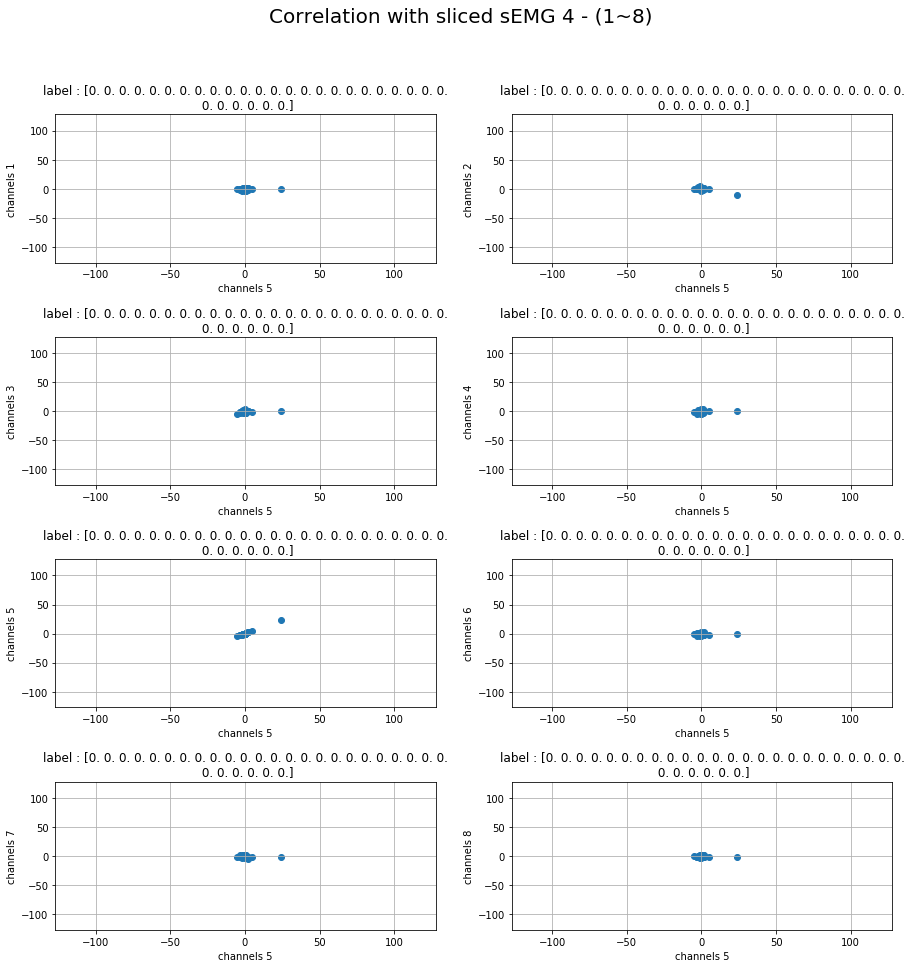

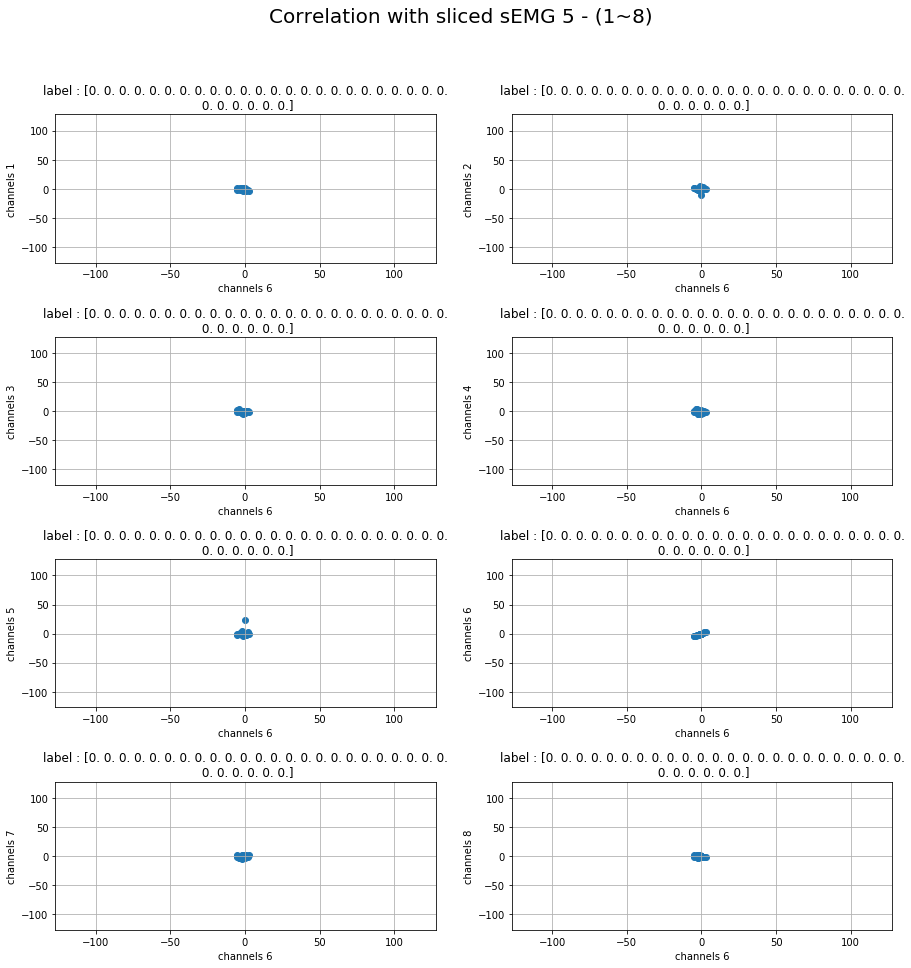

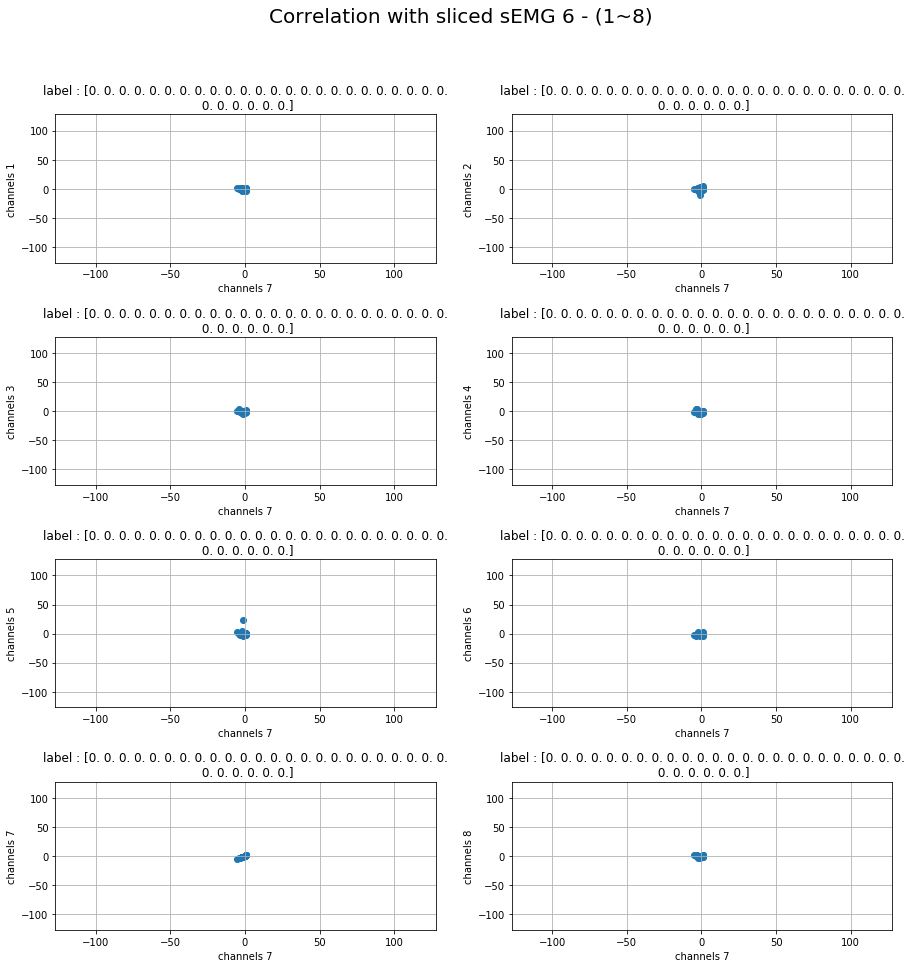

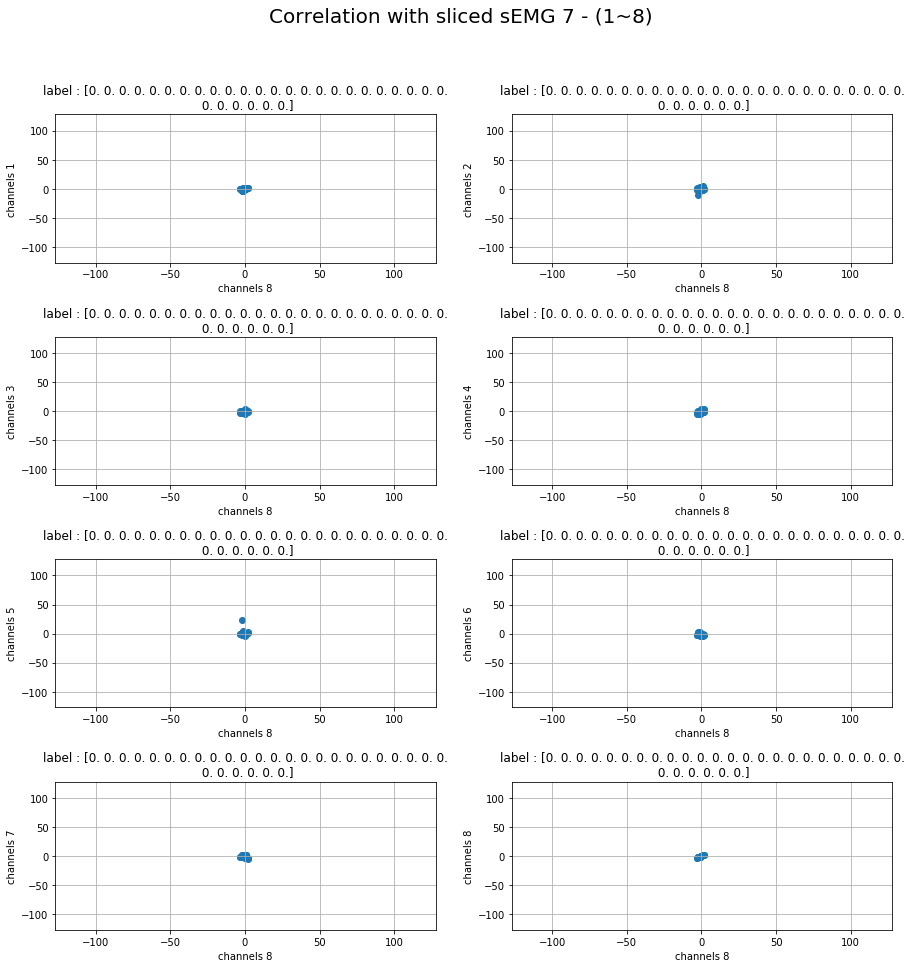

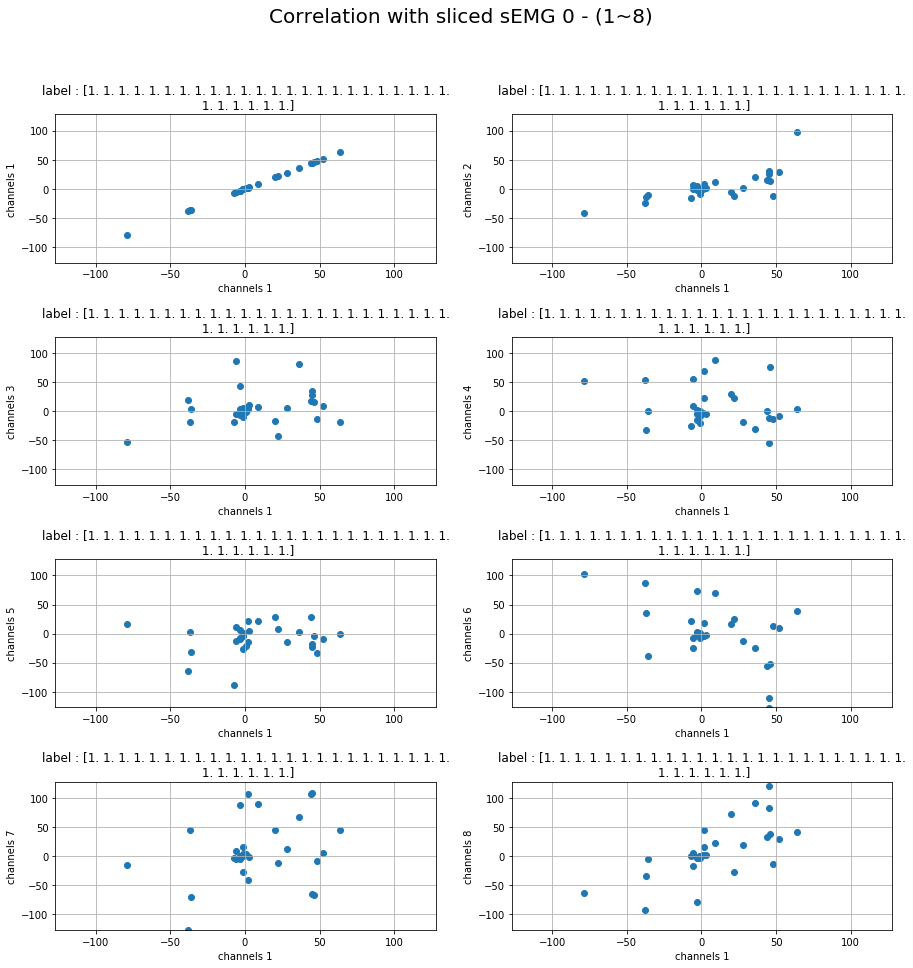

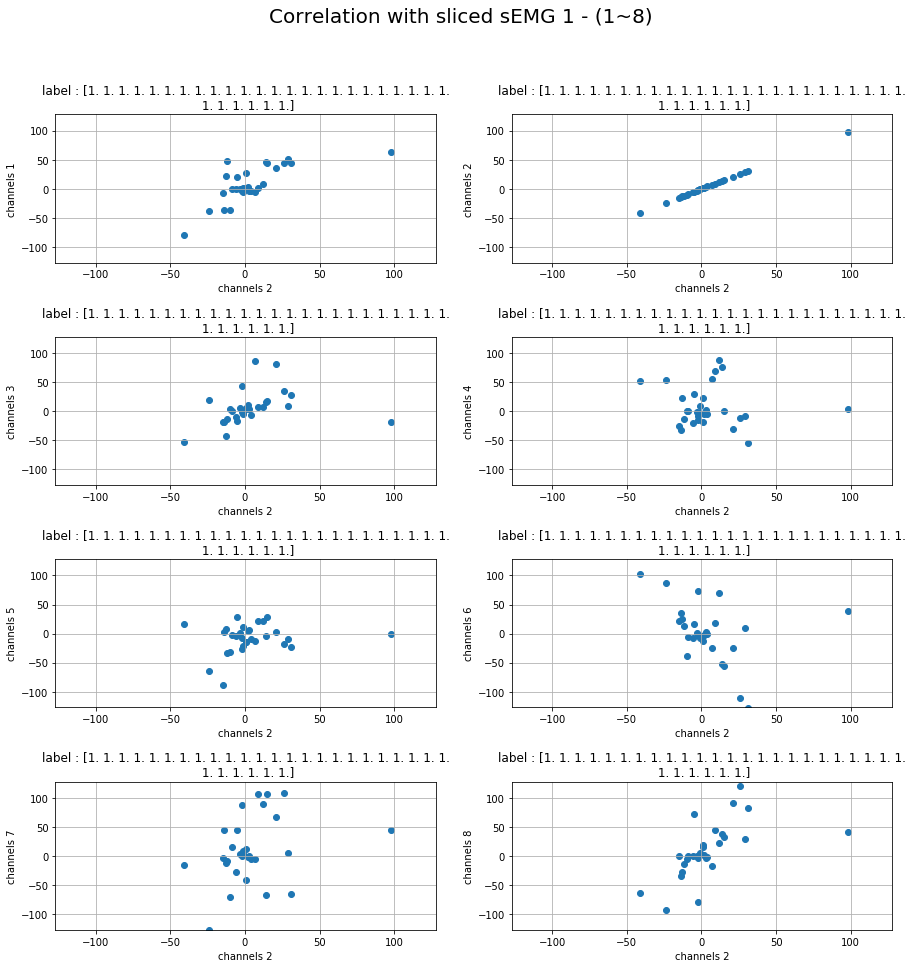

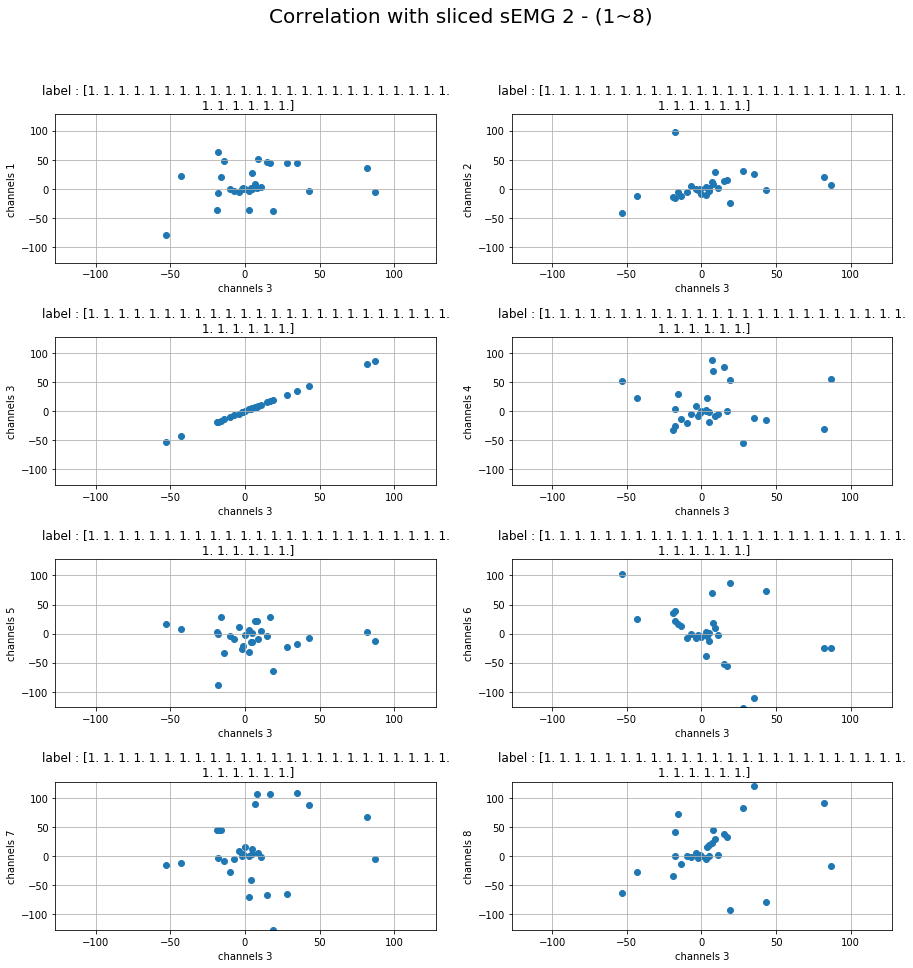

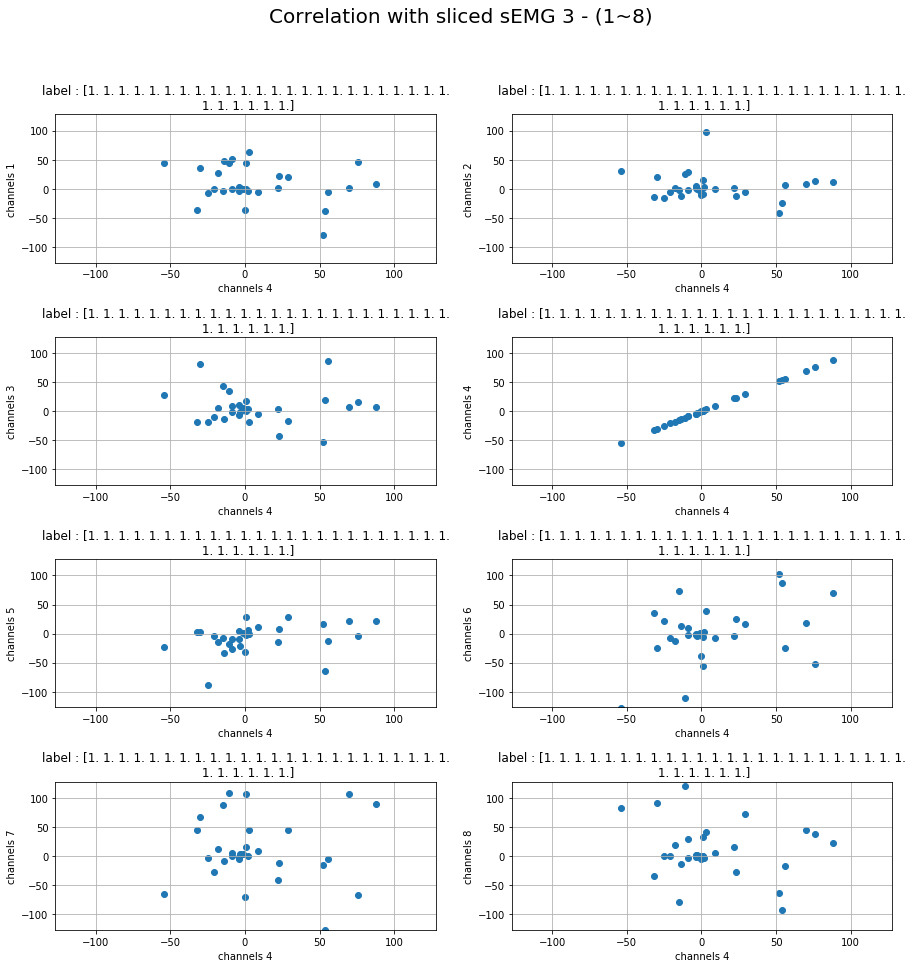

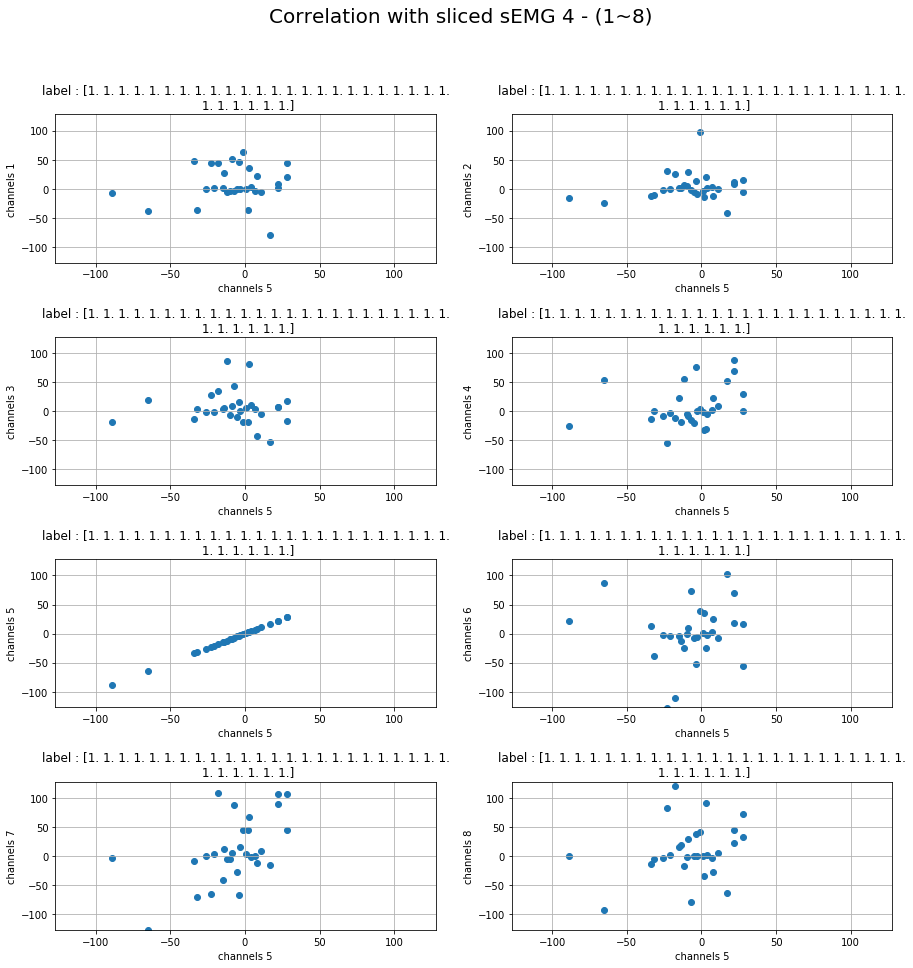

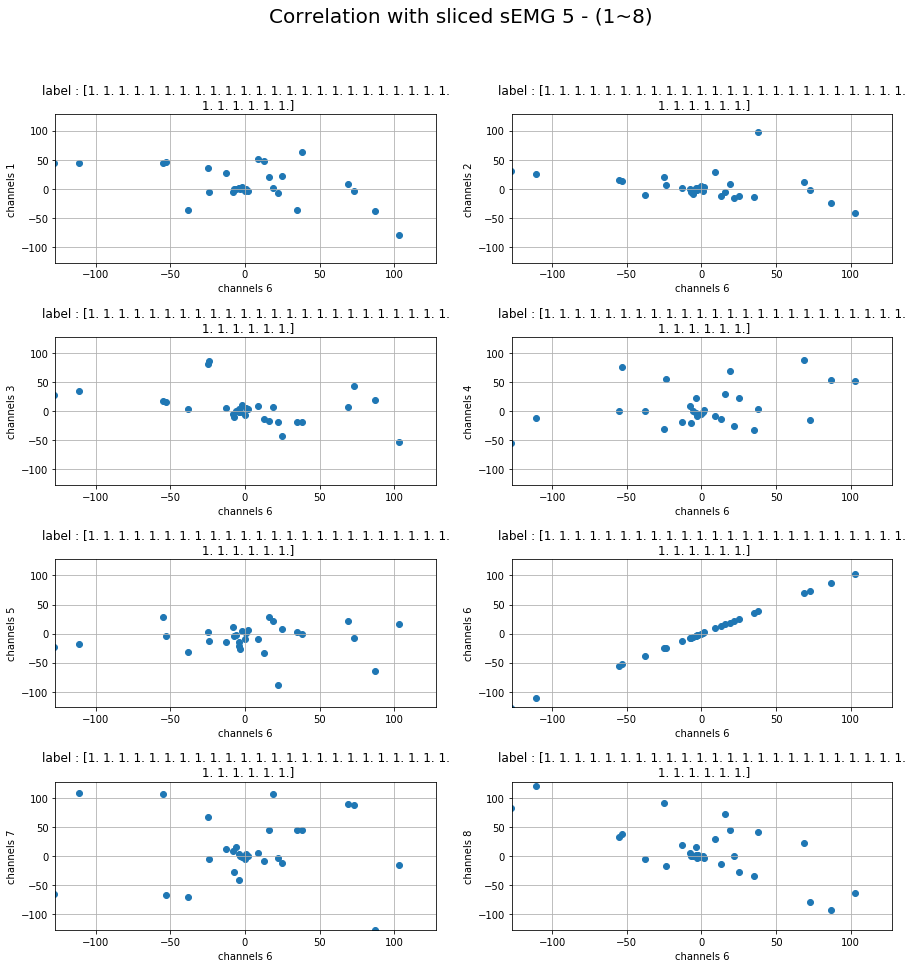

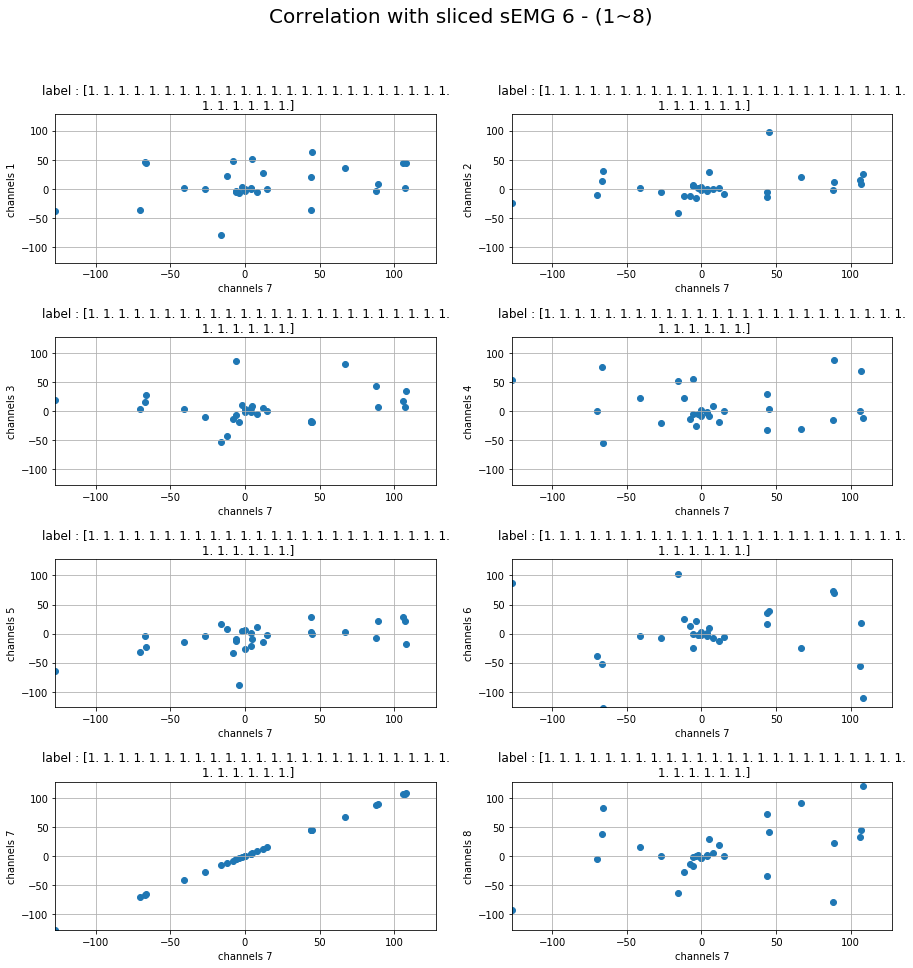

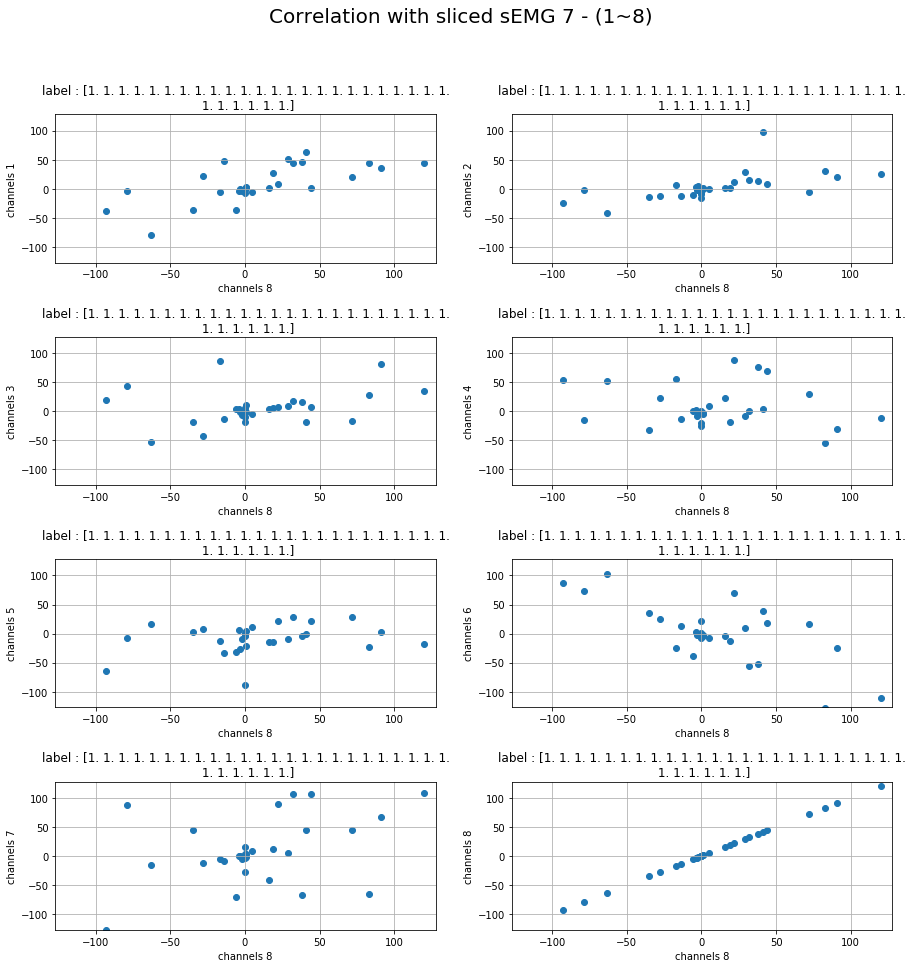

In [7]:
for i in range(num_slicedEMG):
    if i == 2:
        break
    for j in range(sensor_channels):
        fig = plt.figure(figsize=(15, 15))
        fig.suptitle("Correlation with sliced sEMG {} - (1~8)".format(j), fontsize=20)
        
        for k in range(sensor_channels):
            arg = "{}2".format(str(math.ceil(sensor_channels/2))) + str(k+1)
            plt.subplot(arg)
            plt.scatter(sEMGs[j][i], sEMGs[k][i])
            plt.xlabel("channels {}".format(j+1))
            plt.ylabel("channels {}".format(k+1))
            plt.title("label : {}".format(yhats[j][i]))
            plt.xlim([-127, 128])
            plt.ylim([-127, 128])
            plt.grid()
            plt.subplots_adjust(hspace=0.5)
            
        plt.show()

# Linear correlation coefficient r

$$r^{2} = 1 - \frac{\sum_{i=1}^{n}{(\hat{y_{i}} - y_{i})^{2}}}{\sum_{i=1}^{n}(y_{i} - \bar{y})^{2}} $$  

- $\hat{y_{i}}$는 linear regression curve. 즉 하나의 함수($f(x)$)를 의미한다.
- 따라서 식은 $r = 1 - \frac{선형 모델링된\ 함수와\ 데이터간의\ 분산}{y축\ 분산}$
- 이는 상관관계가 얼마나 강한지를 의미한다.  

<br/>

![07aa5db140b70615a15e8631c2d7a2c4](https://user-images.githubusercontent.com/13328380/57057955-b0257200-6ce7-11e9-908c-86d48b93ee44.jpg)

# Why we should consider linear & non-linear correlation?
- 변수 $X$와 변수$Y$의 관계에 대해서 가정을 "선형", "비선형"으로 잘못 분류하게 되면, 계수가 엉뚱하게 나올 수 있다.
- 비선형 관계인 데이터를 선형 관계로 분석하고, 이를 분류하게 될 경우 분류결과가 잘 못 나올 수 있다.(뇌피셜 of Martin)

![Screenshot from 2019-05-02 14-42-57](https://user-images.githubusercontent.com/13328380/57058072-9b95a980-6ce8-11e9-8c37-d64e22f53de8.png)


# [Nonlinear multivariate analysis of Neurophysiological Signals](https://www.researchgate.net/publication/7478280_Nonlinear_multivariate_analysis_of_Neurophysiological_Signals)

필요하다면 논문 참조할 것.  

## 4. Nonlinear correlation coefficient

- 해당 측정(measure)는 비모수 비선형 회귀 계수(nonparametric nonlinear regression coefficient)
    - $X$에 대한 $Y$의 의존성을 가장 일반적인 방식으로 나타낸다.
    > Lopes da Silva et al., 1989; Pijn et al., 1990    

<br/>

- 기본 아이디어는 $X$의 값이 $Y$의 값의 함수로 간주할 수 있으면, 주어진 $Y$의 값을 비선형 회귀 곡선(regression curve)에 따라 예측할 수 있다.
    - $Y$값이 $X$를 입력으로 받는 어떠한 함수 $f$의 출력값으로 간주된다는 이야기
    - $Y = f(X)$  

<br/>

- 회귀 곡선(regression curve)에 따른 $Y$의 분산(variance)는 $X$로 인해 설명되거나, 예측될 수 있기 때문에 설명된 분산(explained variance)라고 함
- 설명되지 않은 분산(unexplained variance)는 설명된 분산(explained variance)에서 원래의 분산를 빼서 추정할 수 있다.  
    
- 상관관계 비율(correlation ratio) $\eta^{2}$는 $Y$의 분산에 대한 감소에 대해서 설명하는 인덱스다.
    - 여기서 $Y$는 $f(X)$를 통해서 얻을 수 있다.
    - $\eta^{2} = \frac{(total\ variance\ -\ unexplained\ variance)}{total\ variance}$  

<br/>

- 연산은 비선형 회귀 단계를 포함하고 있다.
- 따라서 유한한 데이터 포인트를 갖는 두개의 신호 사이에서만 상관비율을 추정할 수 있다.
- 앞서 이야기한 비율측정에 대한 추정은 비선형상관계수 혹은 비선형회귀계수 $h^{2}$라고 불린다.(non-linear correlation coefficient $h^{2}$)  

<br/>   

- 실제로는 $Y$와 $X$에 대한 산점도를 이용해서 연구를 진행하게된다.
- 먼저 $X$의 값들을 bin으로 세분화한다.
- 각 bin에 대해서 중간 점($p_{i}$)의 $X$값과 $Y$($q_{i}$)의 평균값을 계산한다.
- 회귀 곡선(regression curve)는 결과 포인트 ($p_{i}, q_{i}$)를 직선 세그먼트(line segment)로 연결해서 근사화한다.  

<br/>          

- 변형된 신호 $X$와 $Y$ 사이의 non-linear correlation coefficient는 아래와 같이 계산할 수 있다.  
- 이는 $\eta^{2}$를 위한 estimator다.

$$ h^{2}_{y|x} = \frac{\sum_{k=1}^{N} y(k)^{2} - \sum_{k=1}^{N}(y(k) - f(x_{i}))^{2}}{\sum_{k=1}^{N}y(k)^{2}}$$  

> 여기서 $f(x_{i})$는 비선형 회귀 곡선(non-linear regression curve)의 선형 조각별 근사(linear piecewise approximation)이다.  

- 위의 식은 아래처럼 써도 무방한듯...
    - 결국은 linear correlation coefficient와 같은 식이다.
    - 차이는 $f(x)$가 linear냐 non-linear냐가 중요한 것이다.
    
$$h^{2} = r^{2}_{nl} = 1 - \frac{\sum_{i=1}^{n}{(y_{i} - f(x_{i}))^{2}}}{\sum_{i=1}^{n}(y_{i} - \bar{y})^{2}} $$  

<br/>

- 반대 방향 $h^{2}_{x|y}$는 유사하게 구할 수 있다.

# [The nonlinear association analysis of the EEG brain data in the process of bistable image perception](http://lib.physcon.ru/file?id=79407a14680f)


- 결국은 두개의 신호의 연합(degree of association) 강도를 추정하고, 두 신호간에 시간지연함수(function of time shift($\tau$))로 비선형상관계수(nonlinear correlation coefficient $h^{2}$)를 구해서 지연된 신호인것인지 계산한다.
- 해당 방식은 신호가 선형이던 비선형이던간에 적용할 수 있는 이점으로 인해서 다른 신호처리 방법들(coherence, cross-correlation)보다 강력하다.

### Method

내가 해석한 내용을 순차적으로 풀어봄

- 일단 x축을 특정 개수의 bin으로 나눔
    - 여기서 bin은 x축 기점으로만 나눔.
    - y축은 bin을 나누지 않음  
  
<br/>
  
- 이제 각 bin마다 x축의 범위 [n, m]이 존재함
    - x축 범위에 대응하는 y축의 값들도 존재함
    
<br/>

- 각 bin에서 x축의 중간값을 정함. 
$$p_{i} = \frac{m-n}{2}$$
- 각 bin에서 y축의 중간값을 정함. 
$$q_{i} = \frac{1}{m-n}\sum_{k=m}^{N=n}{f(x_{k})}$$

<br>

### Approach

- bin을 32개로 나눔 (data quantization level is $[-128, 127]$, range of x axis is $[n, n+8]$)
- 채널 1과 나머지 채널(1~8)사이의 비선형 회귀곡선(non-linear regression curve)을 그림

#### binning

![binning](https://user-images.githubusercontent.com/13328380/57056823-eb23a780-6cdf-11e9-8bfe-d7c49eb6076c.png)

#### Getting mean point from each bins

![getting_Point](https://user-images.githubusercontent.com/13328380/57056824-eb23a780-6cdf-11e9-844b-b984d6a13926.png)

#### make non-linear regression curve using linear piecewise approximation

![make_nonlinear_fn](https://user-images.githubusercontent.com/13328380/57056822-eb23a780-6cdf-11e9-90f3-c1249a402972.png)

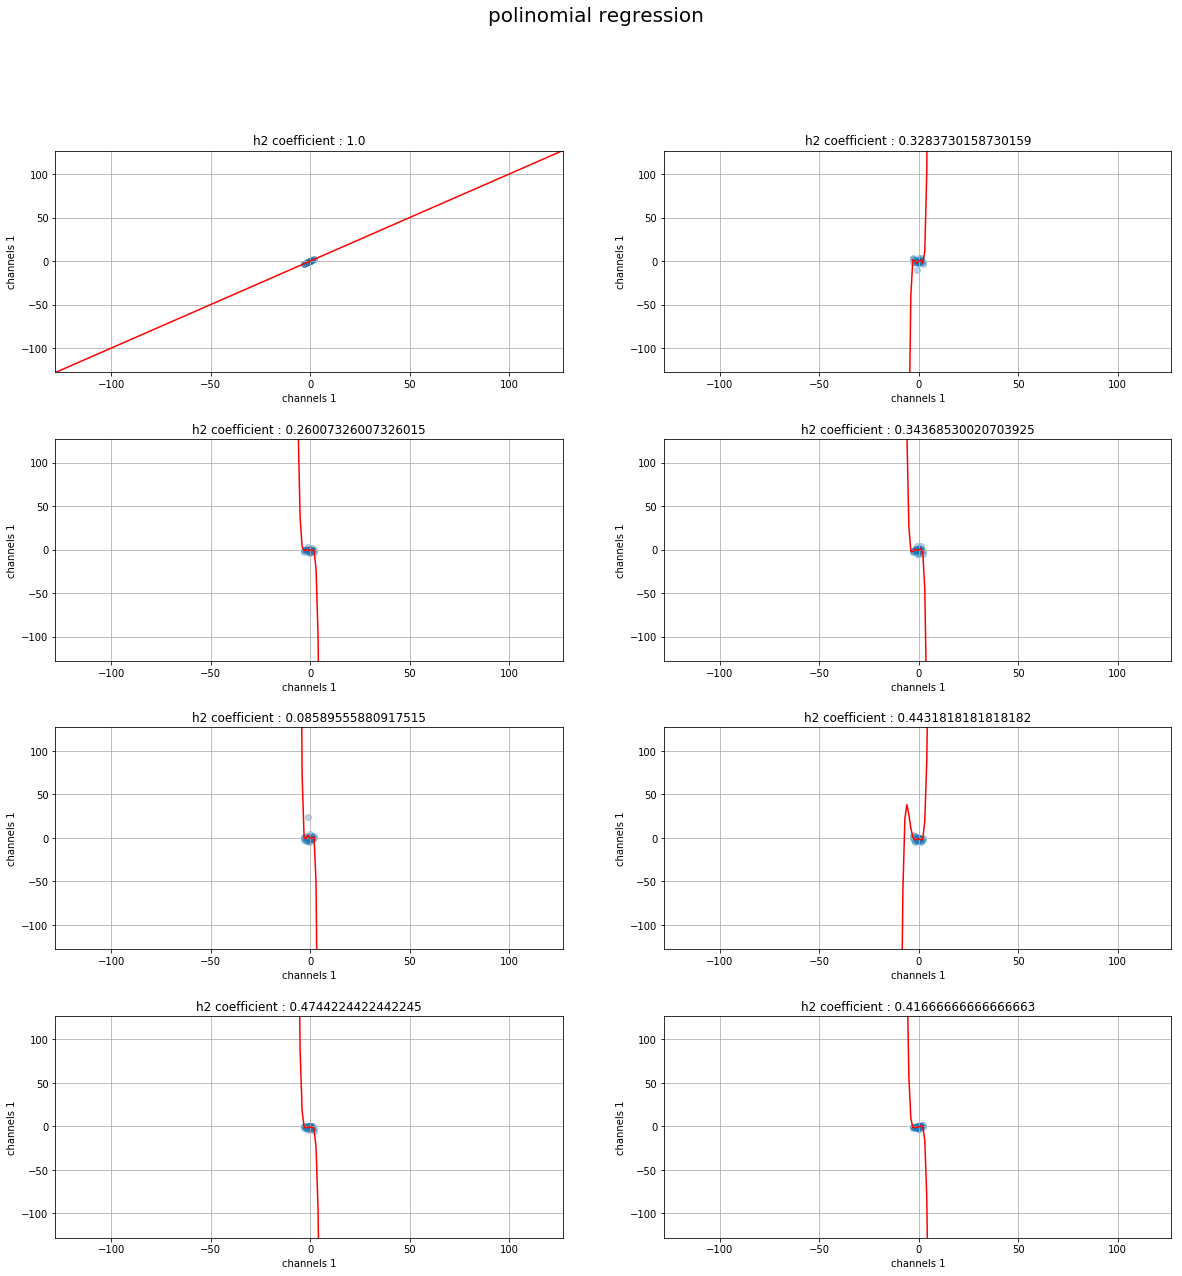

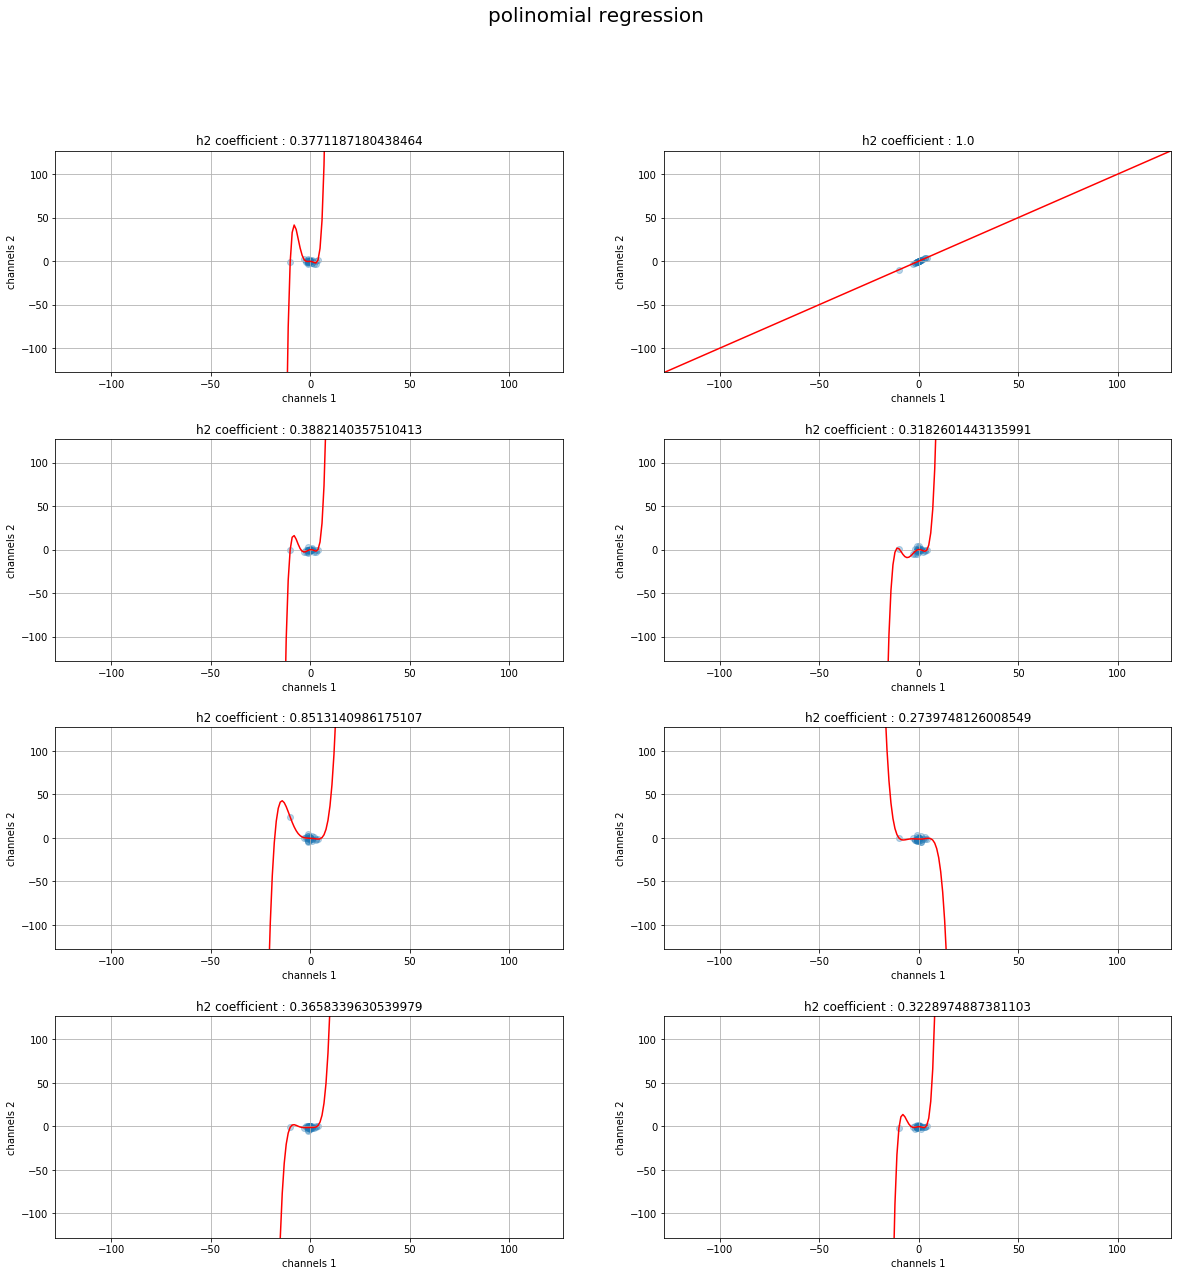

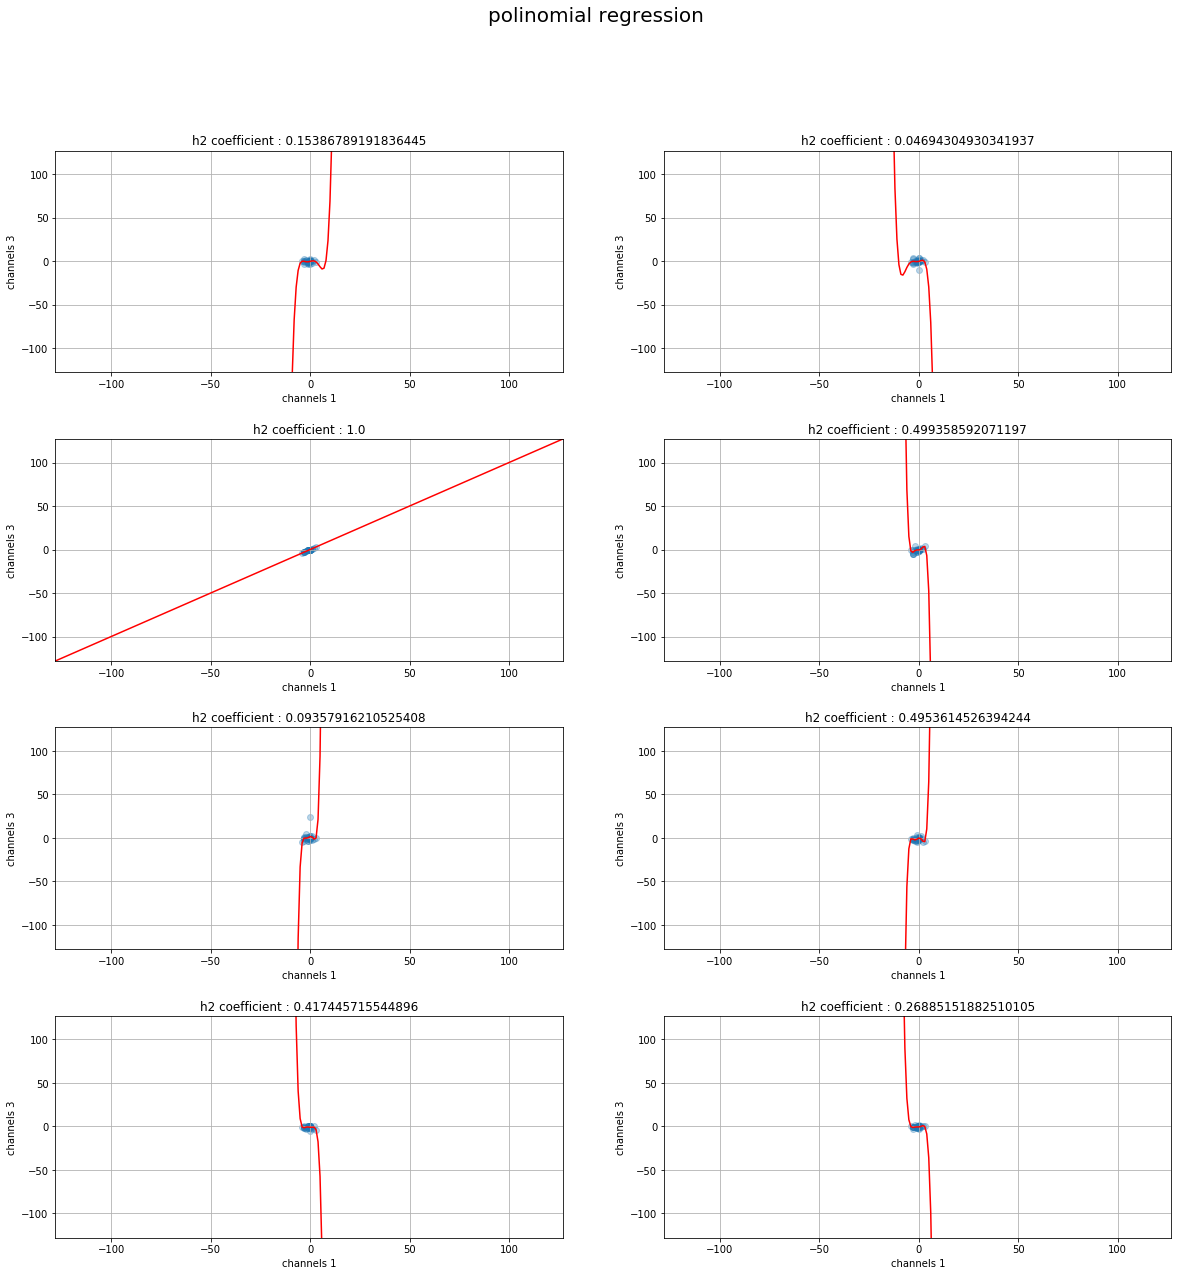

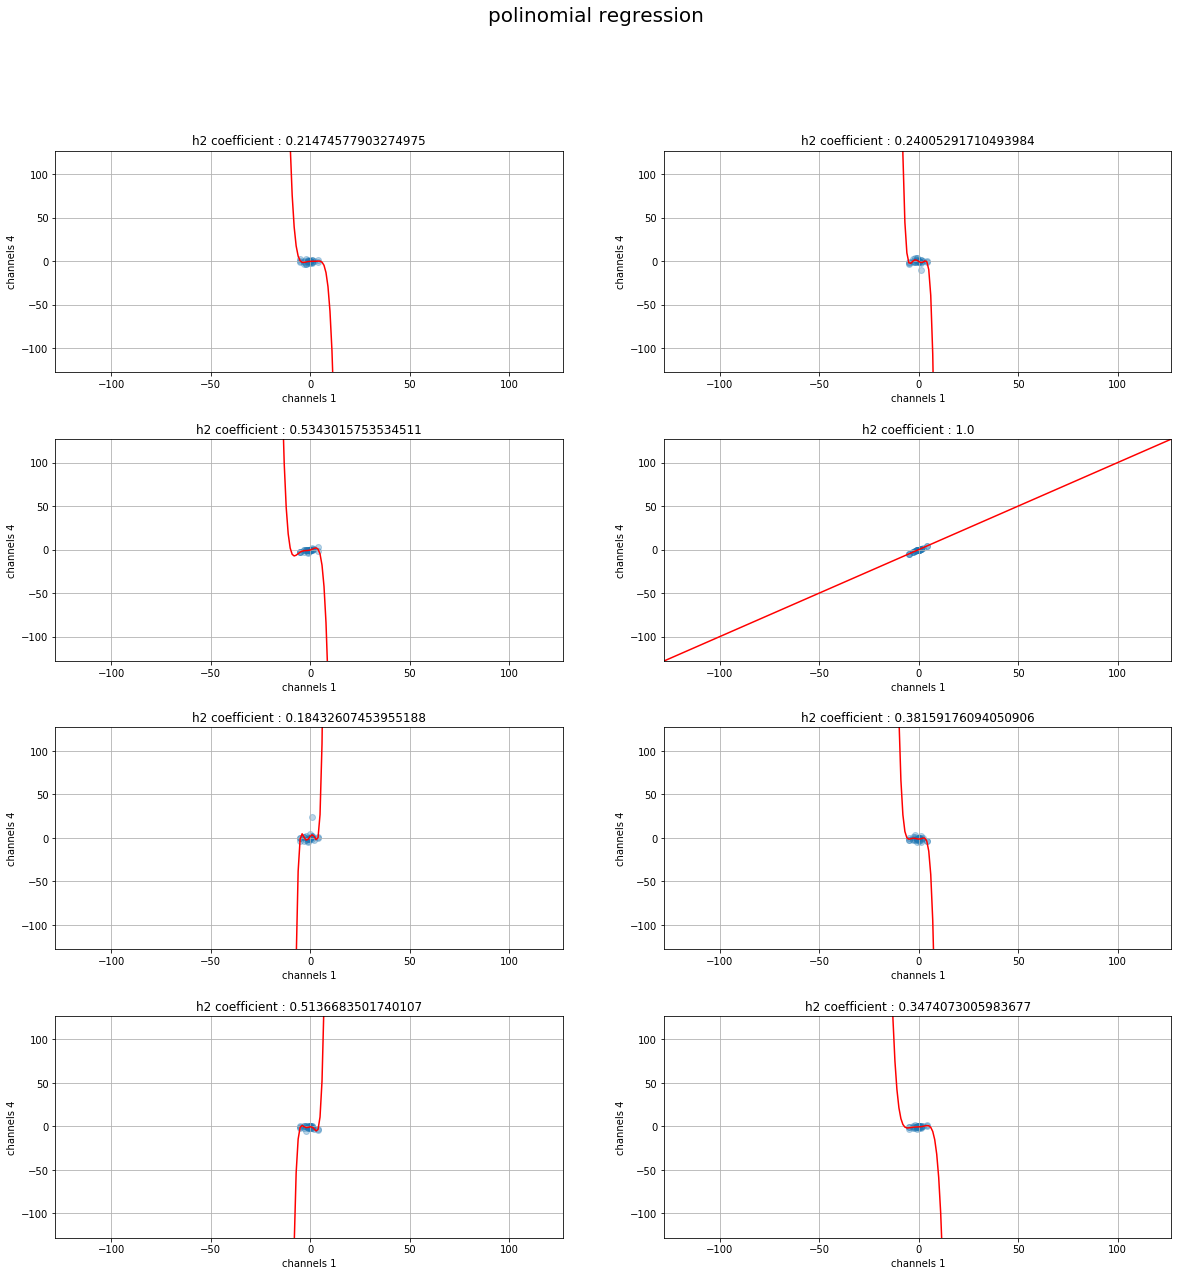

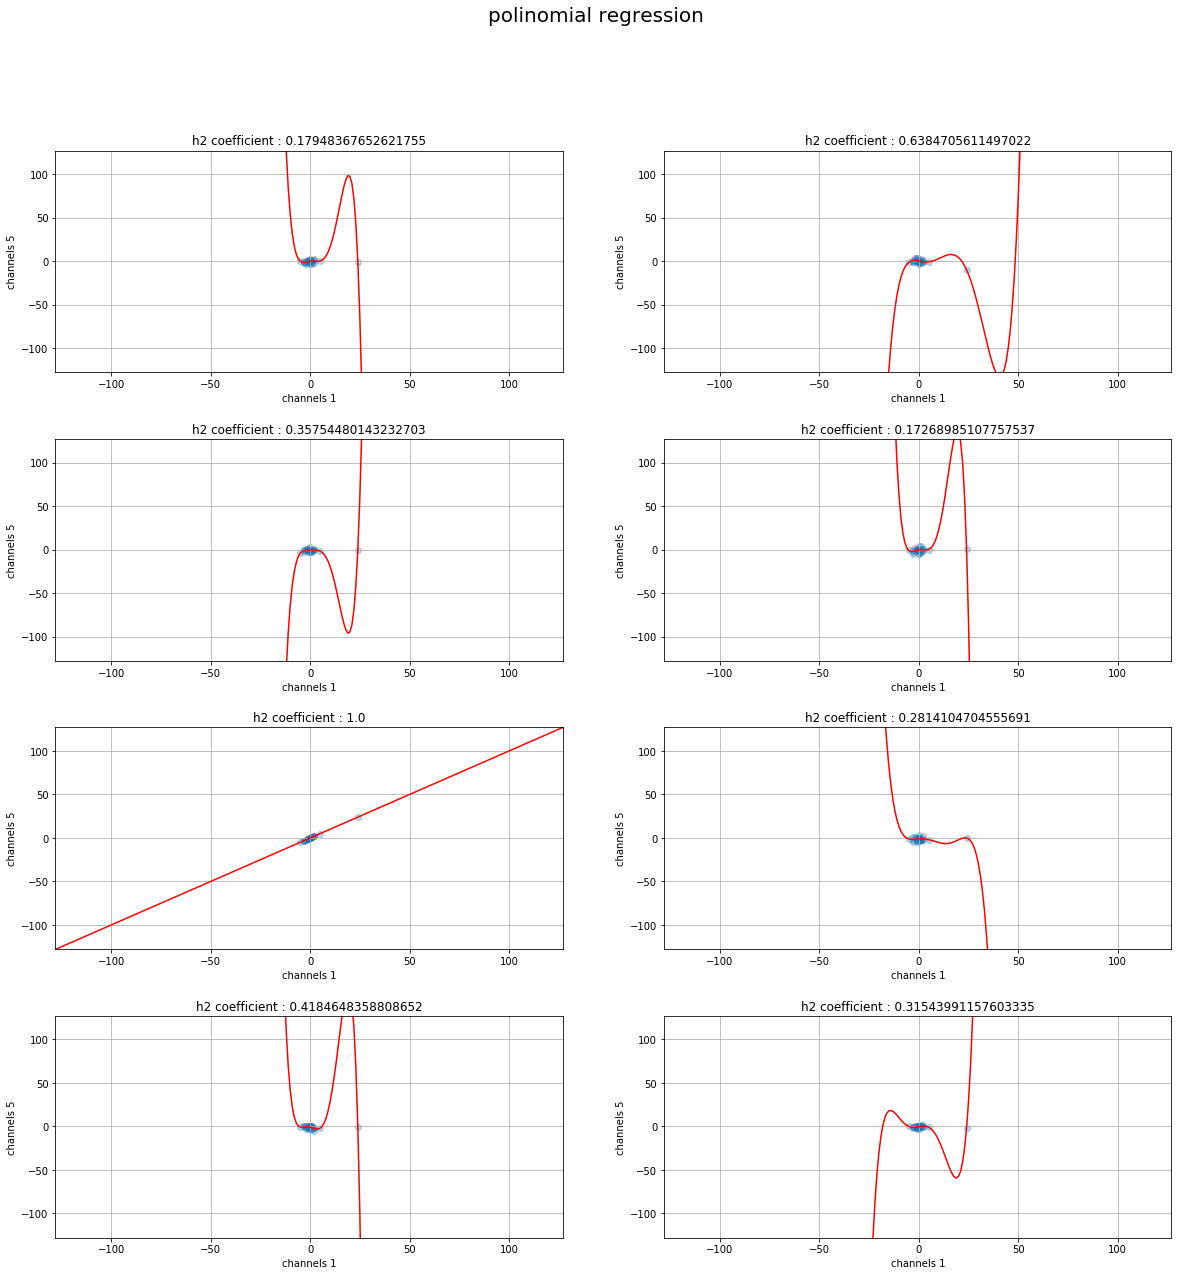

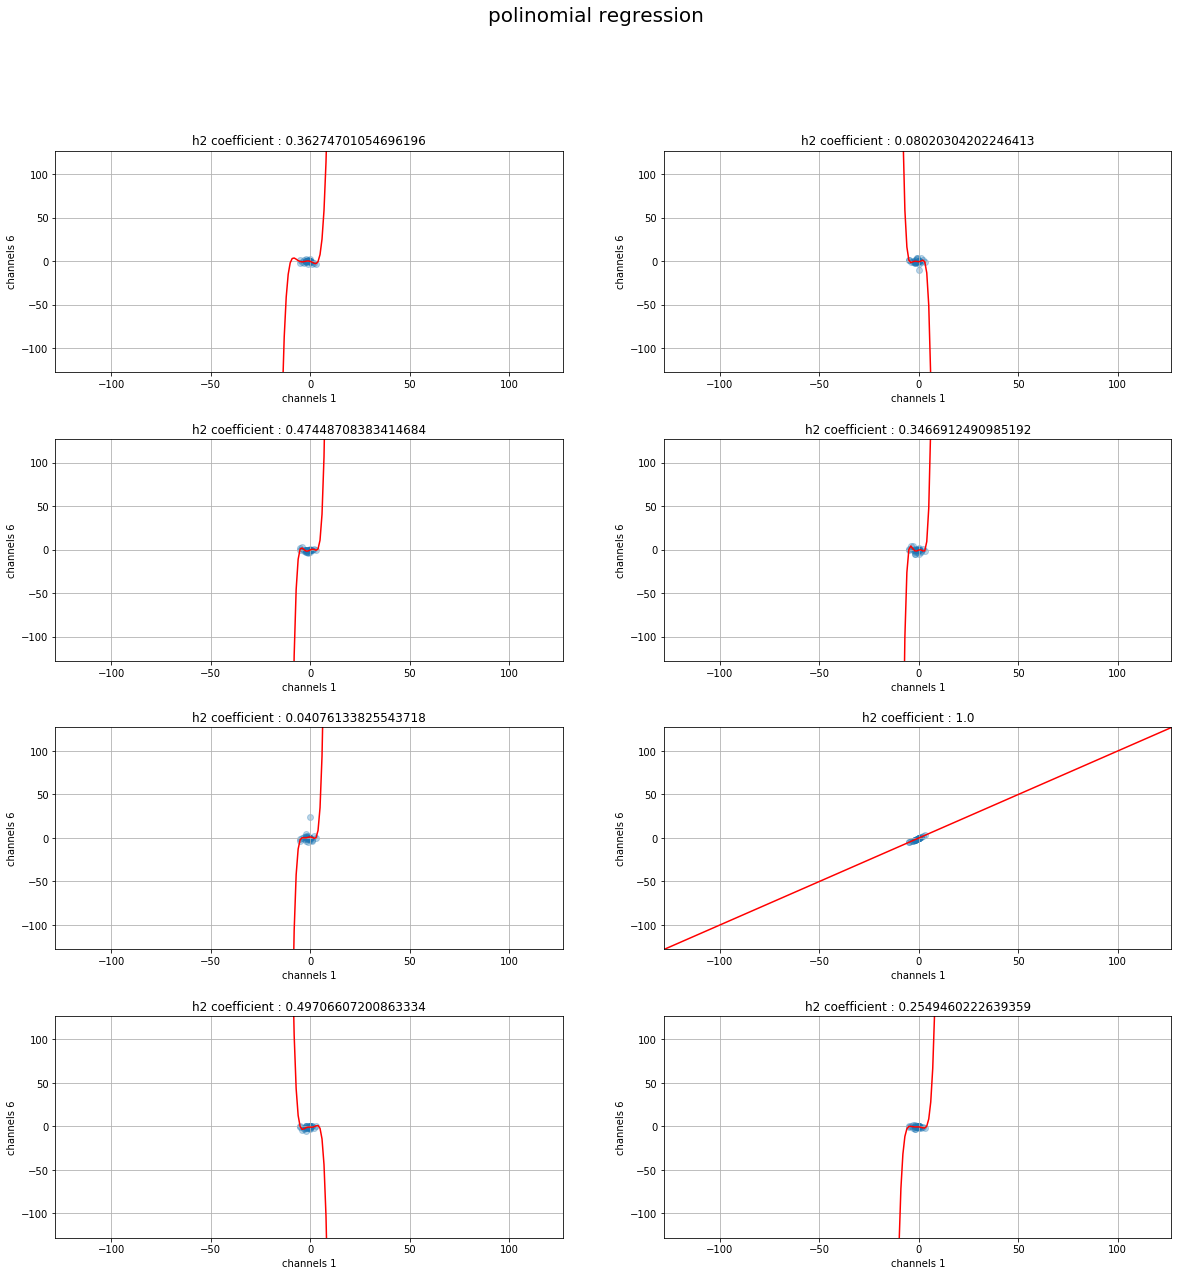

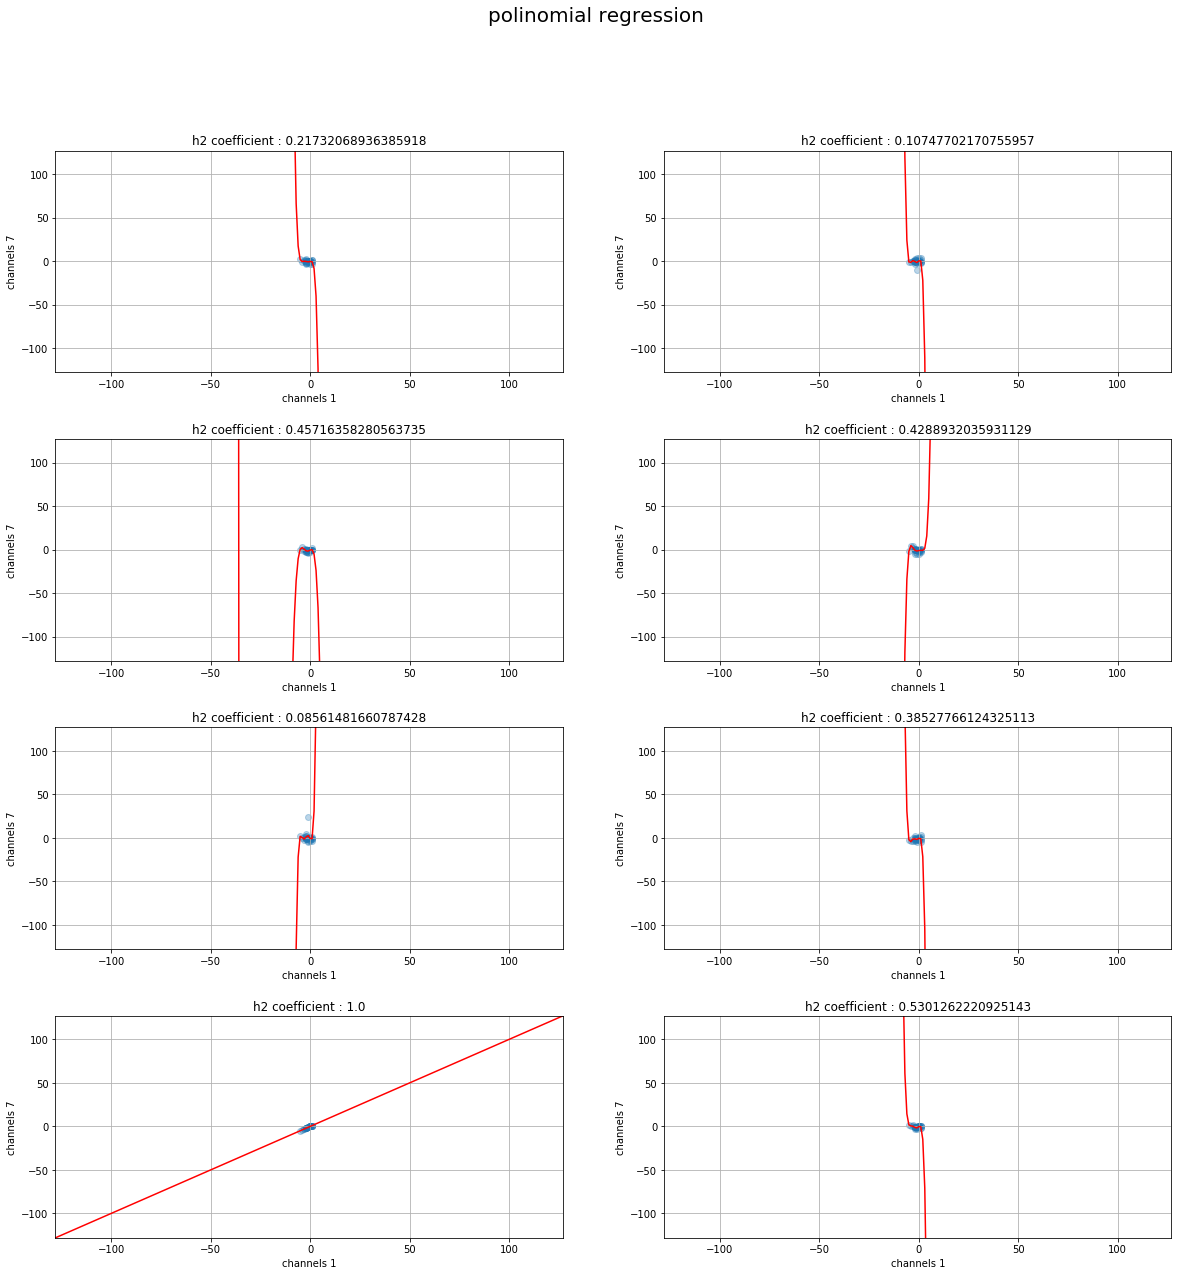

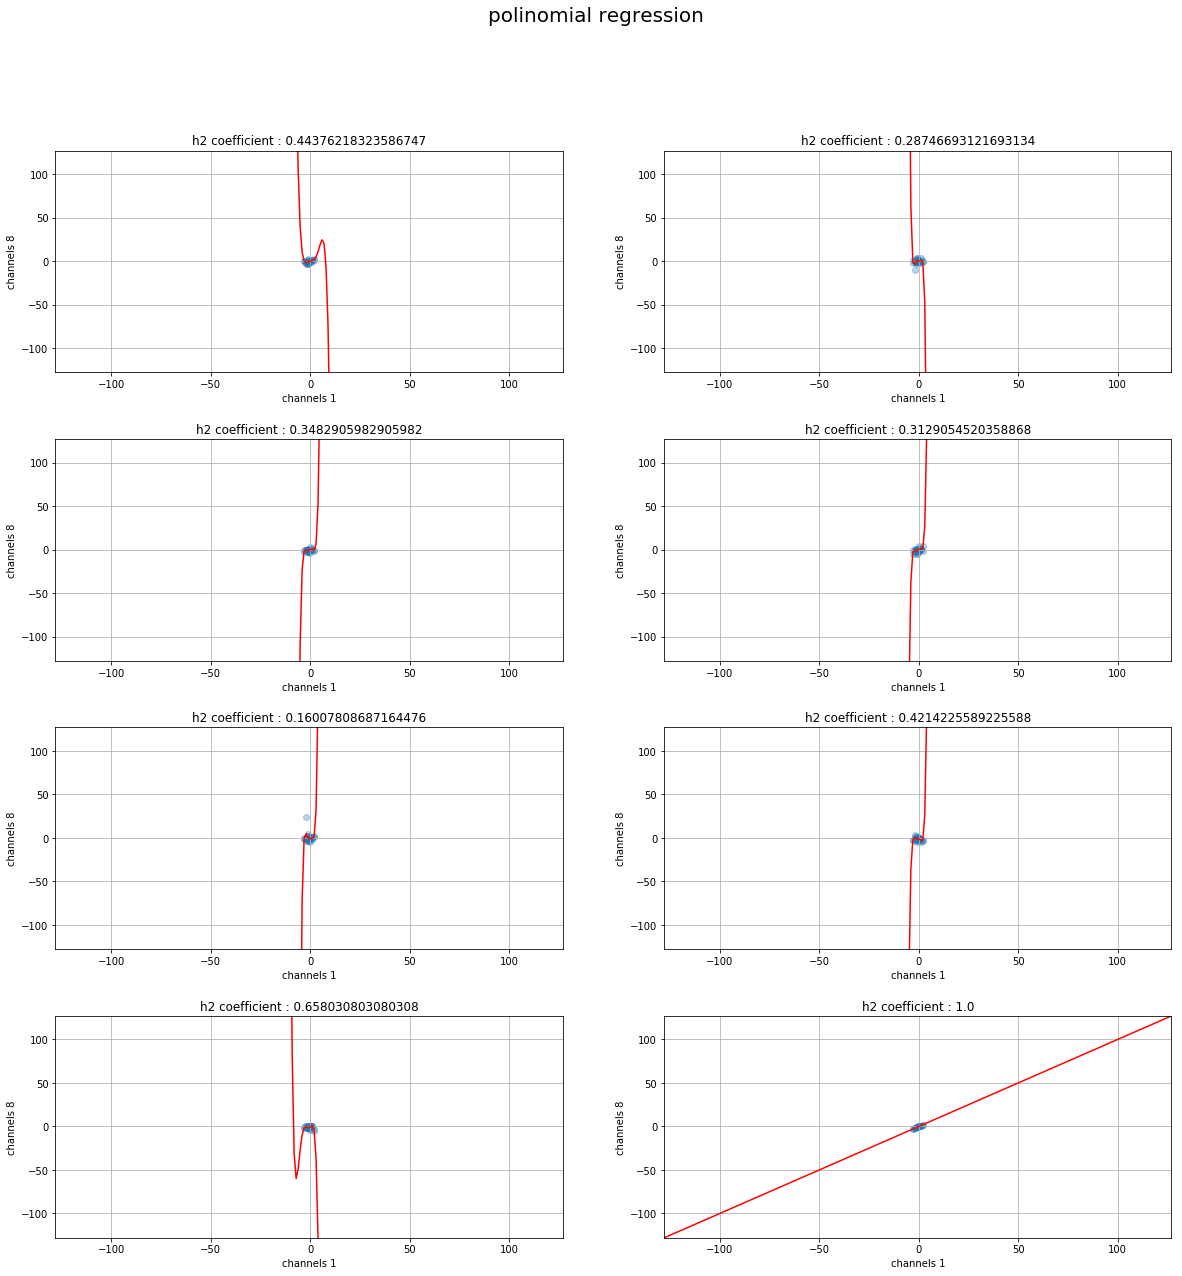

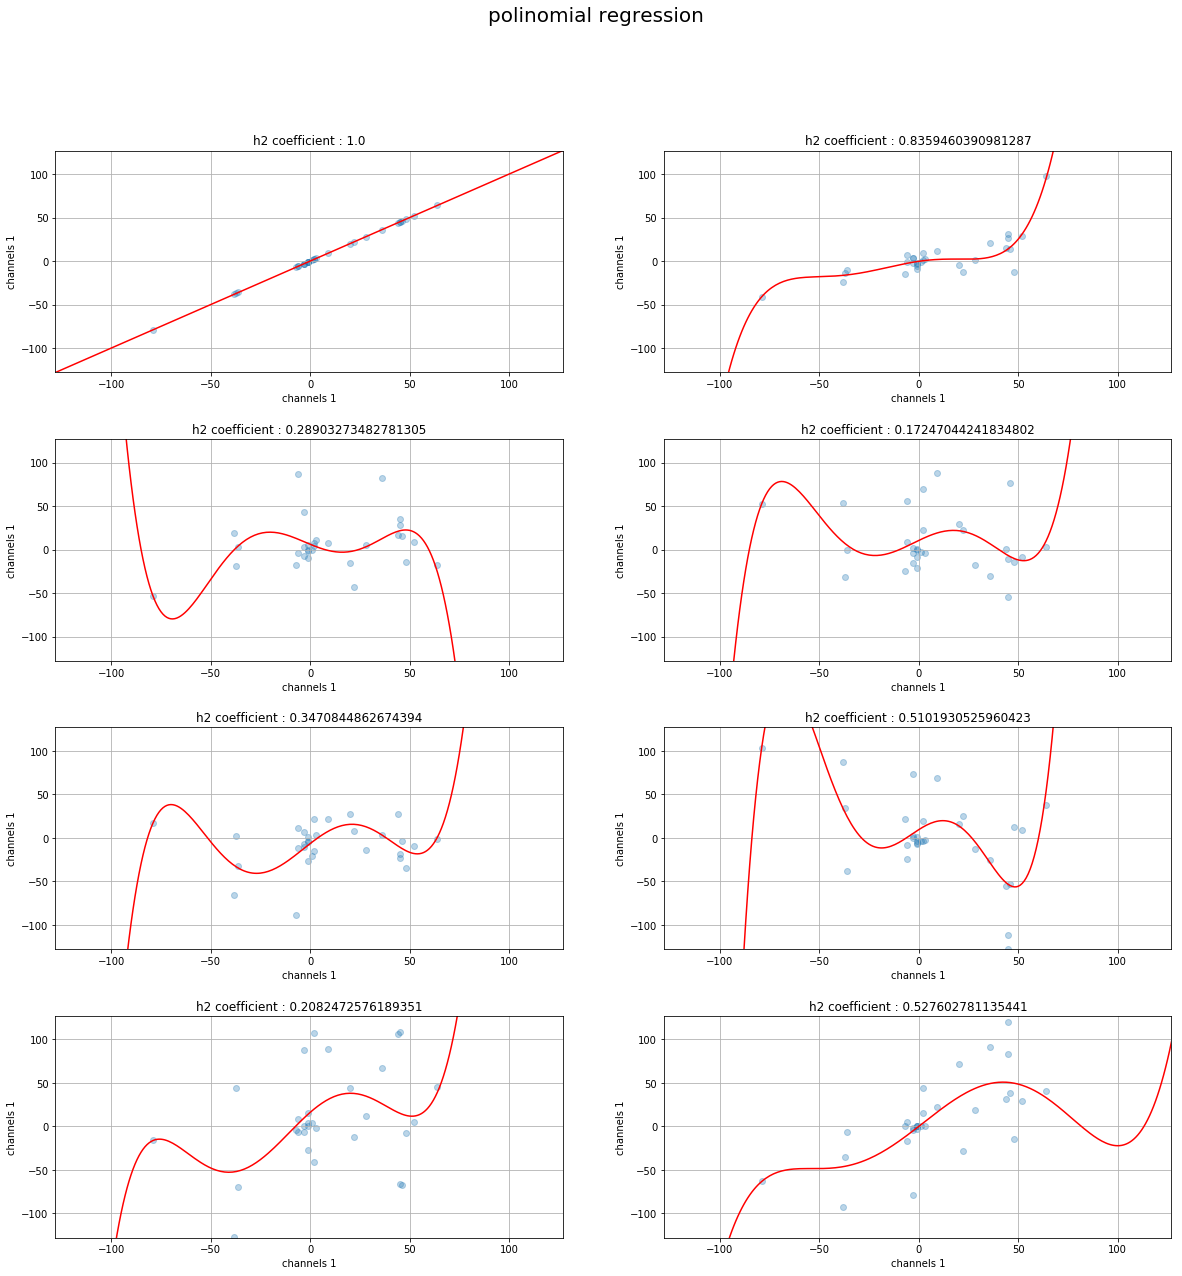

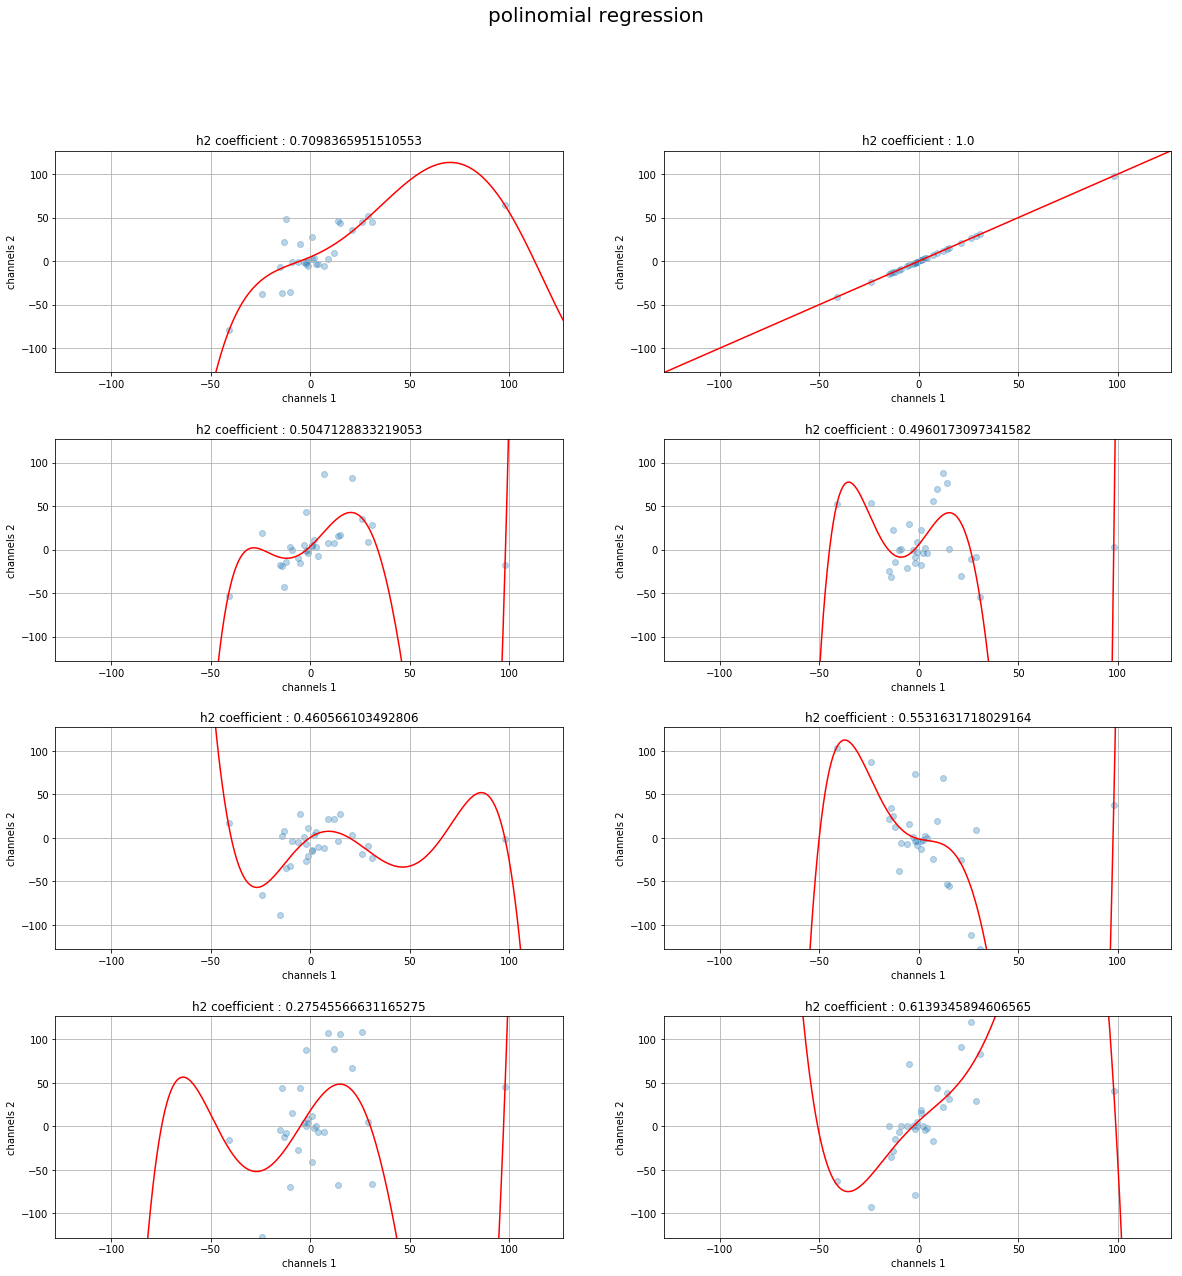

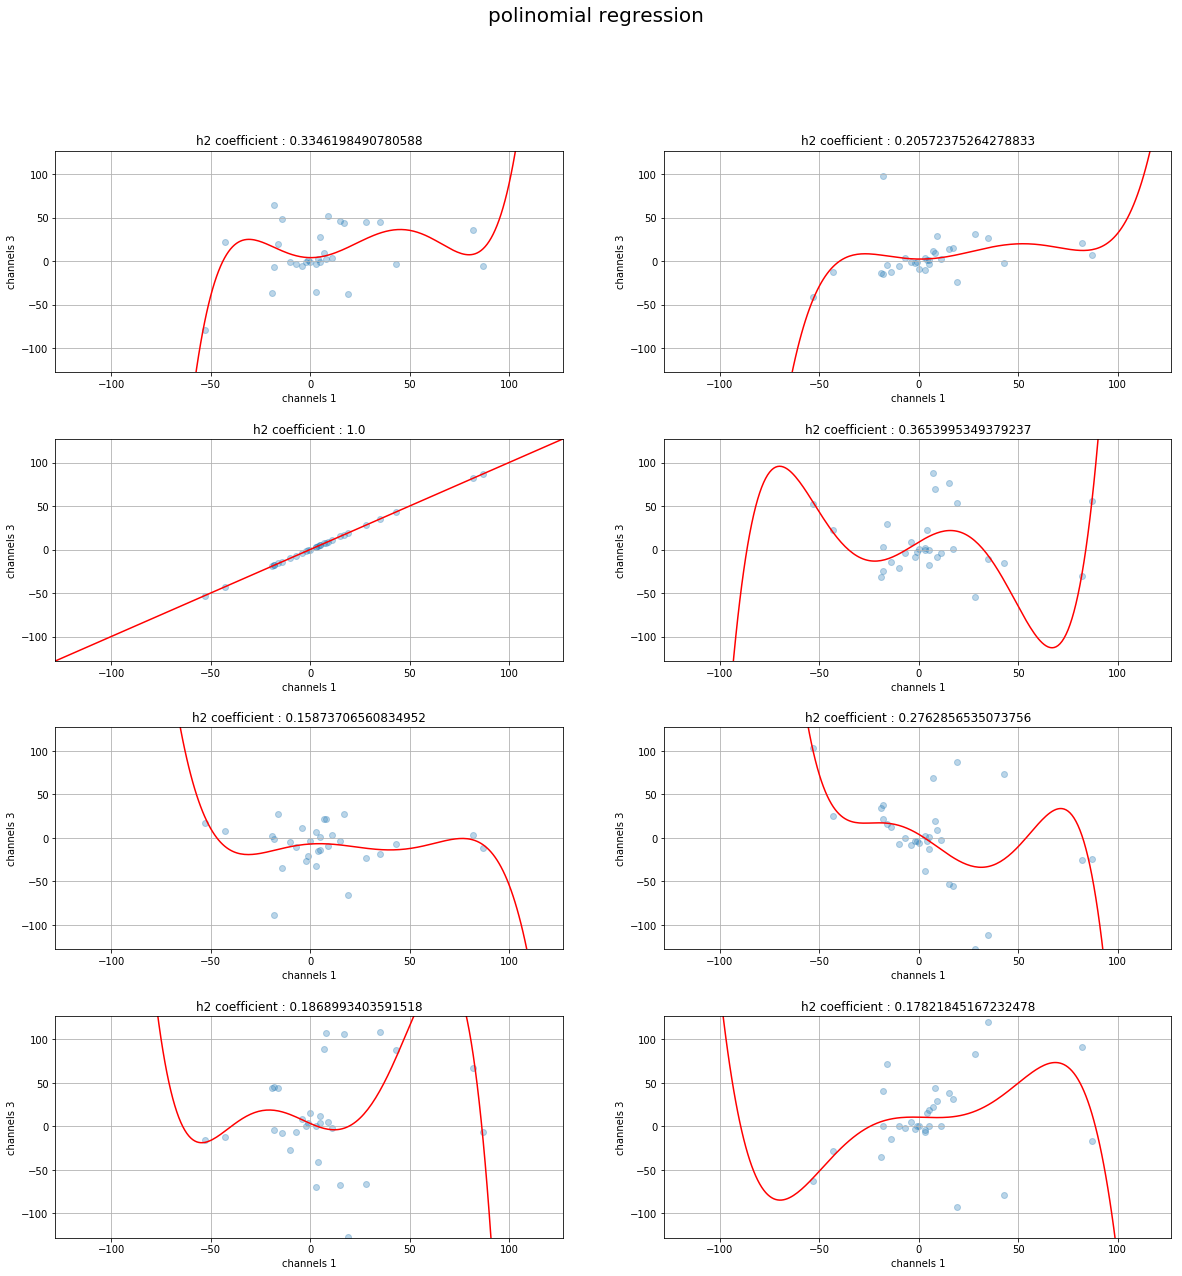

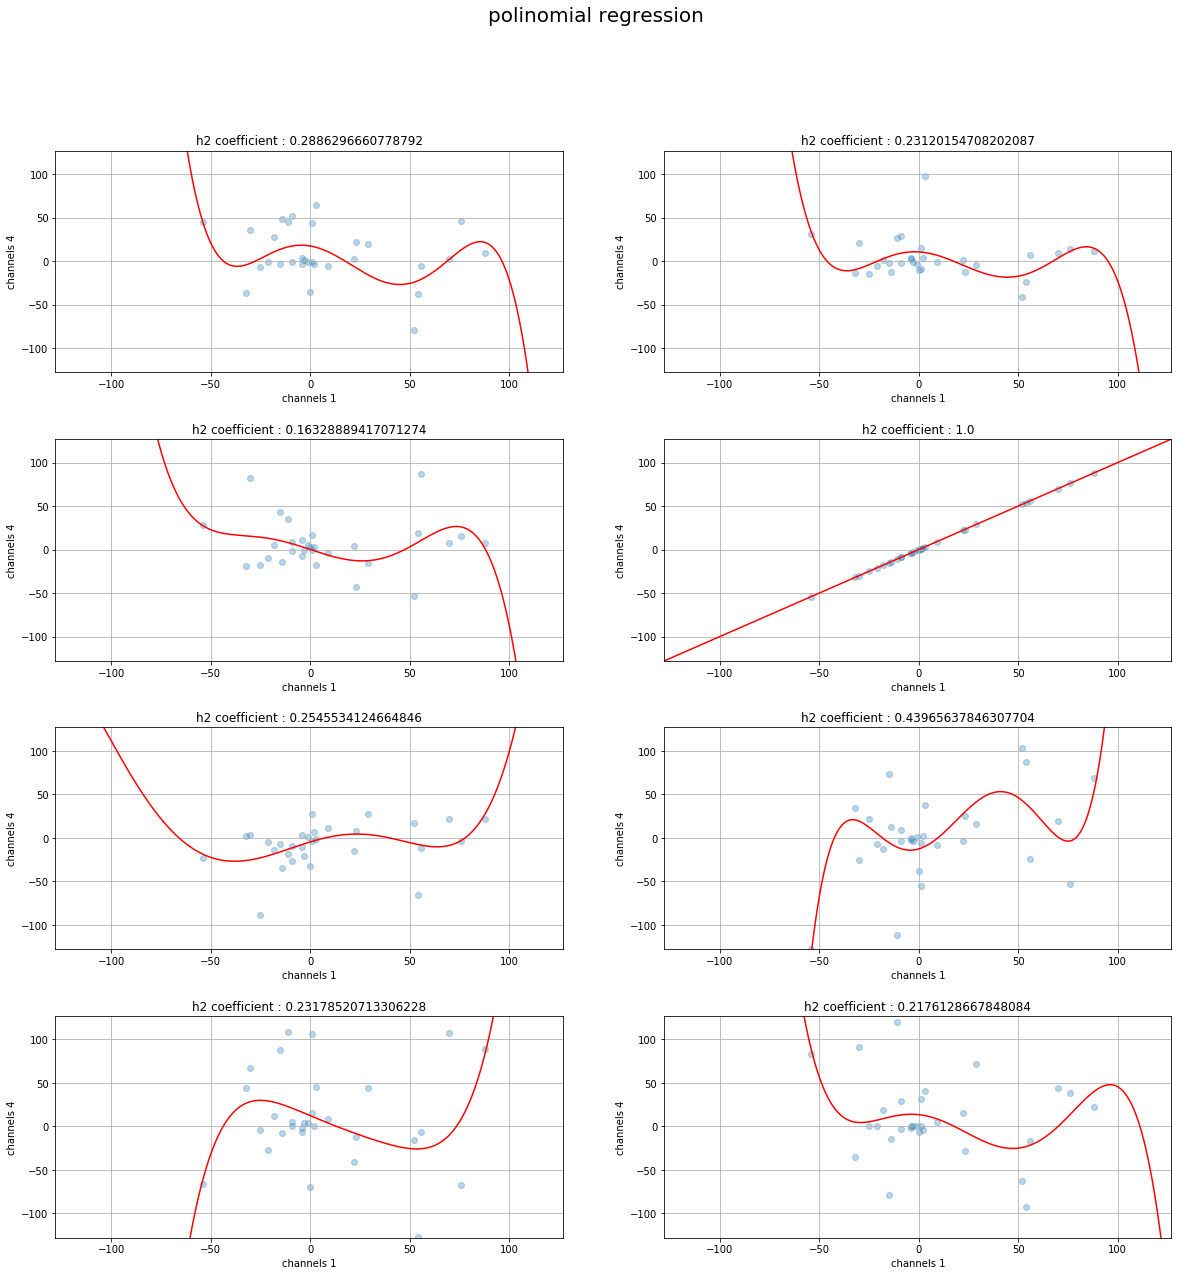

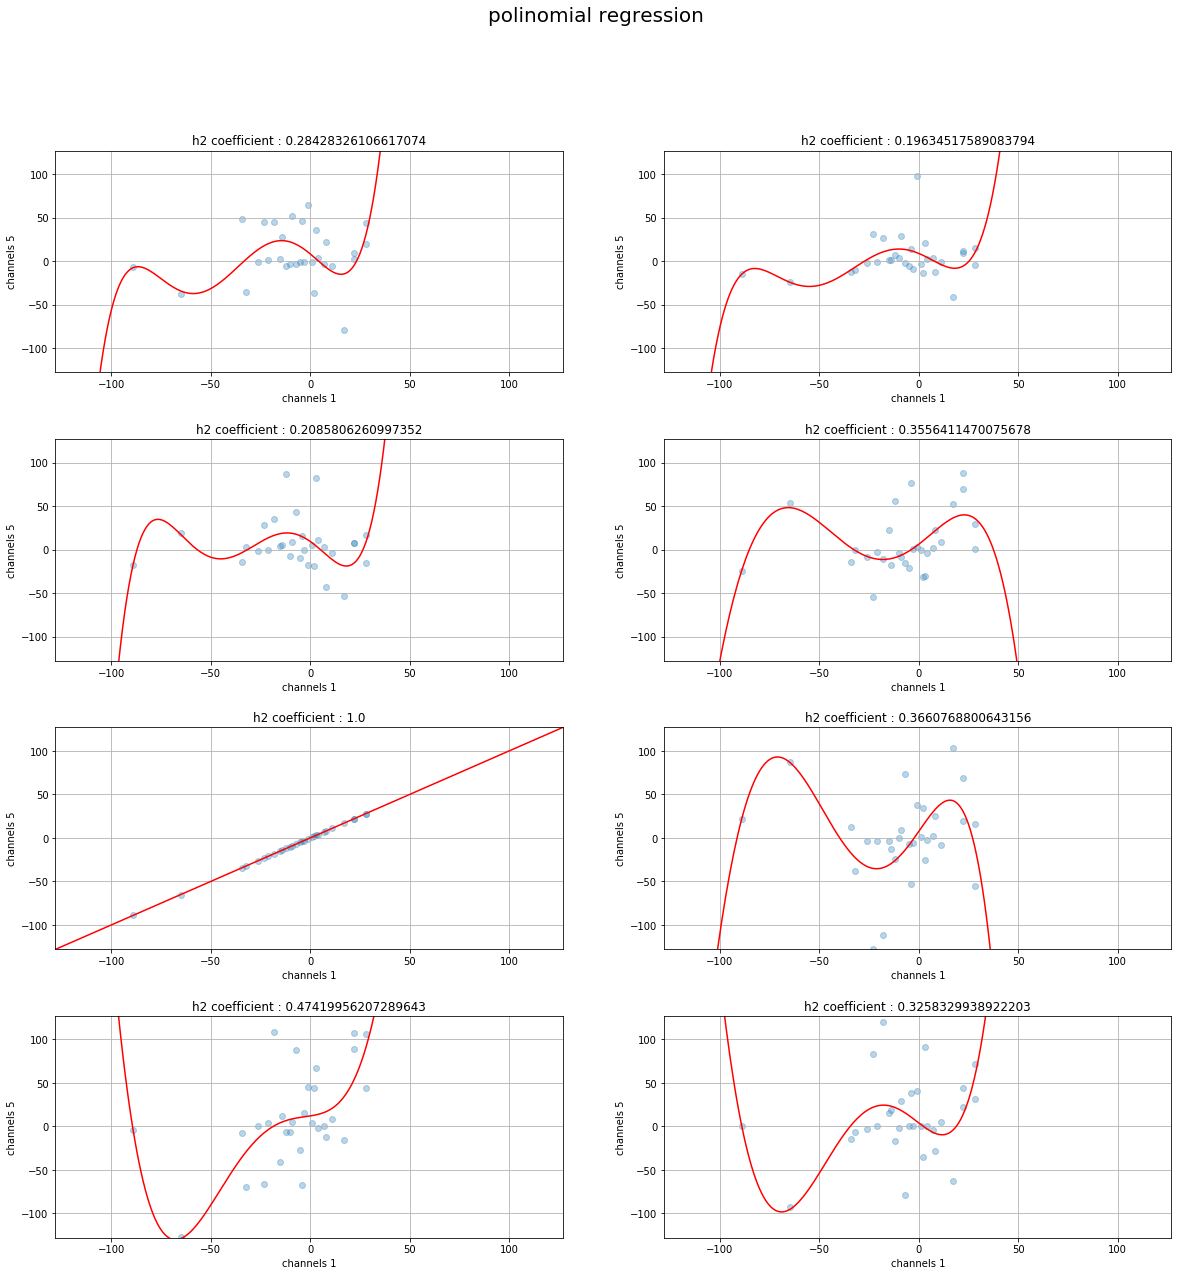

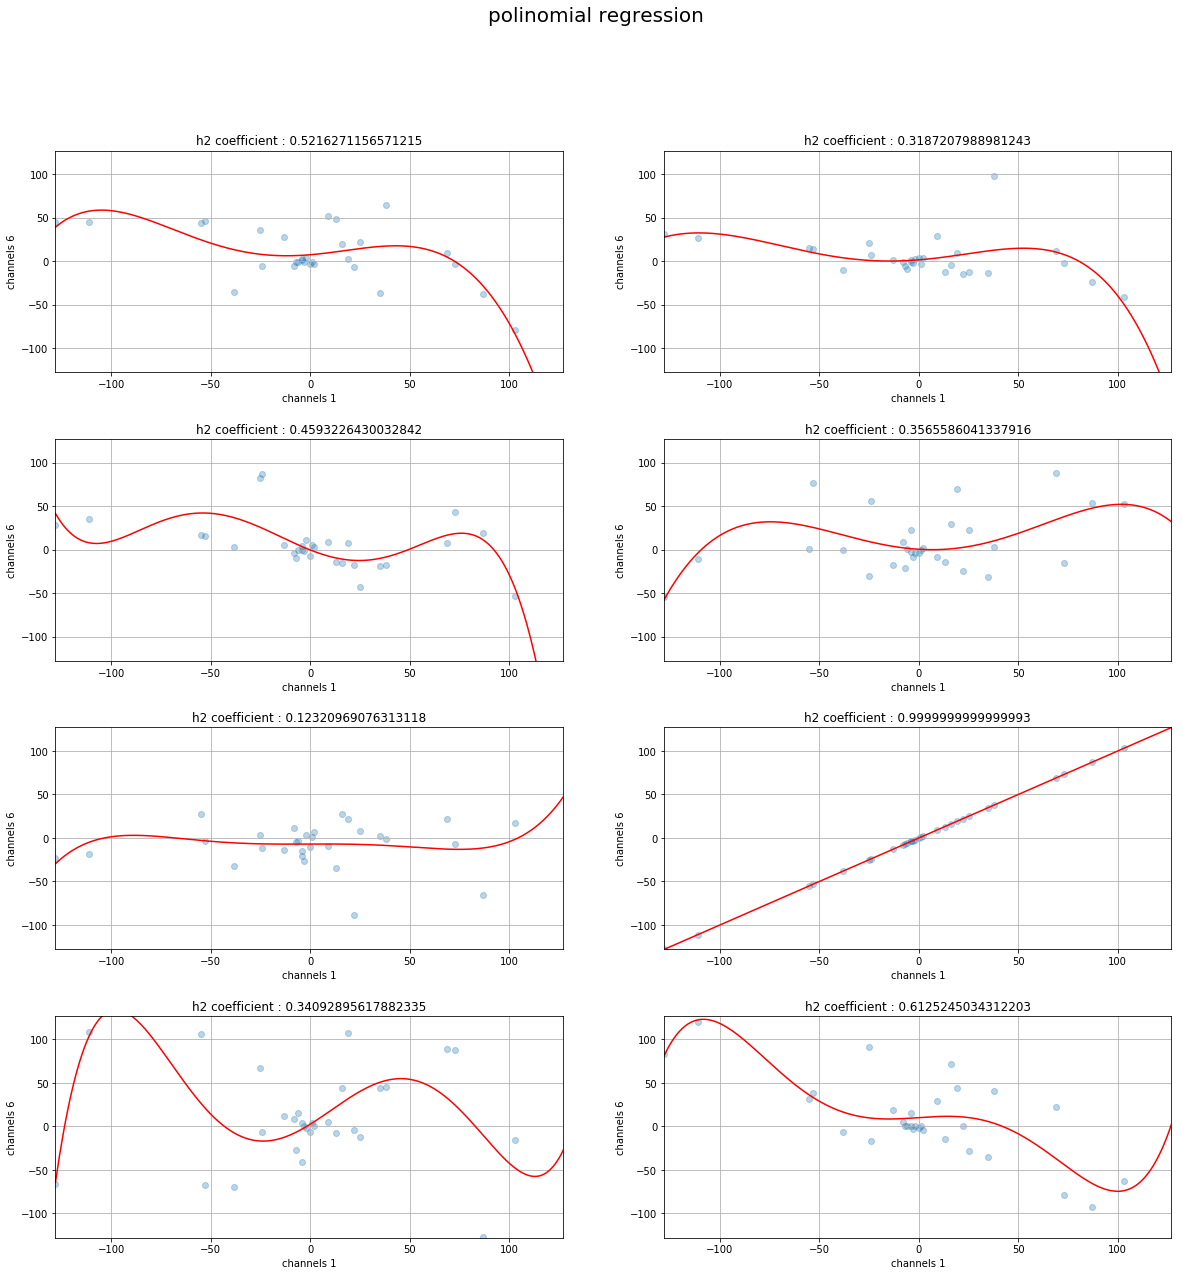

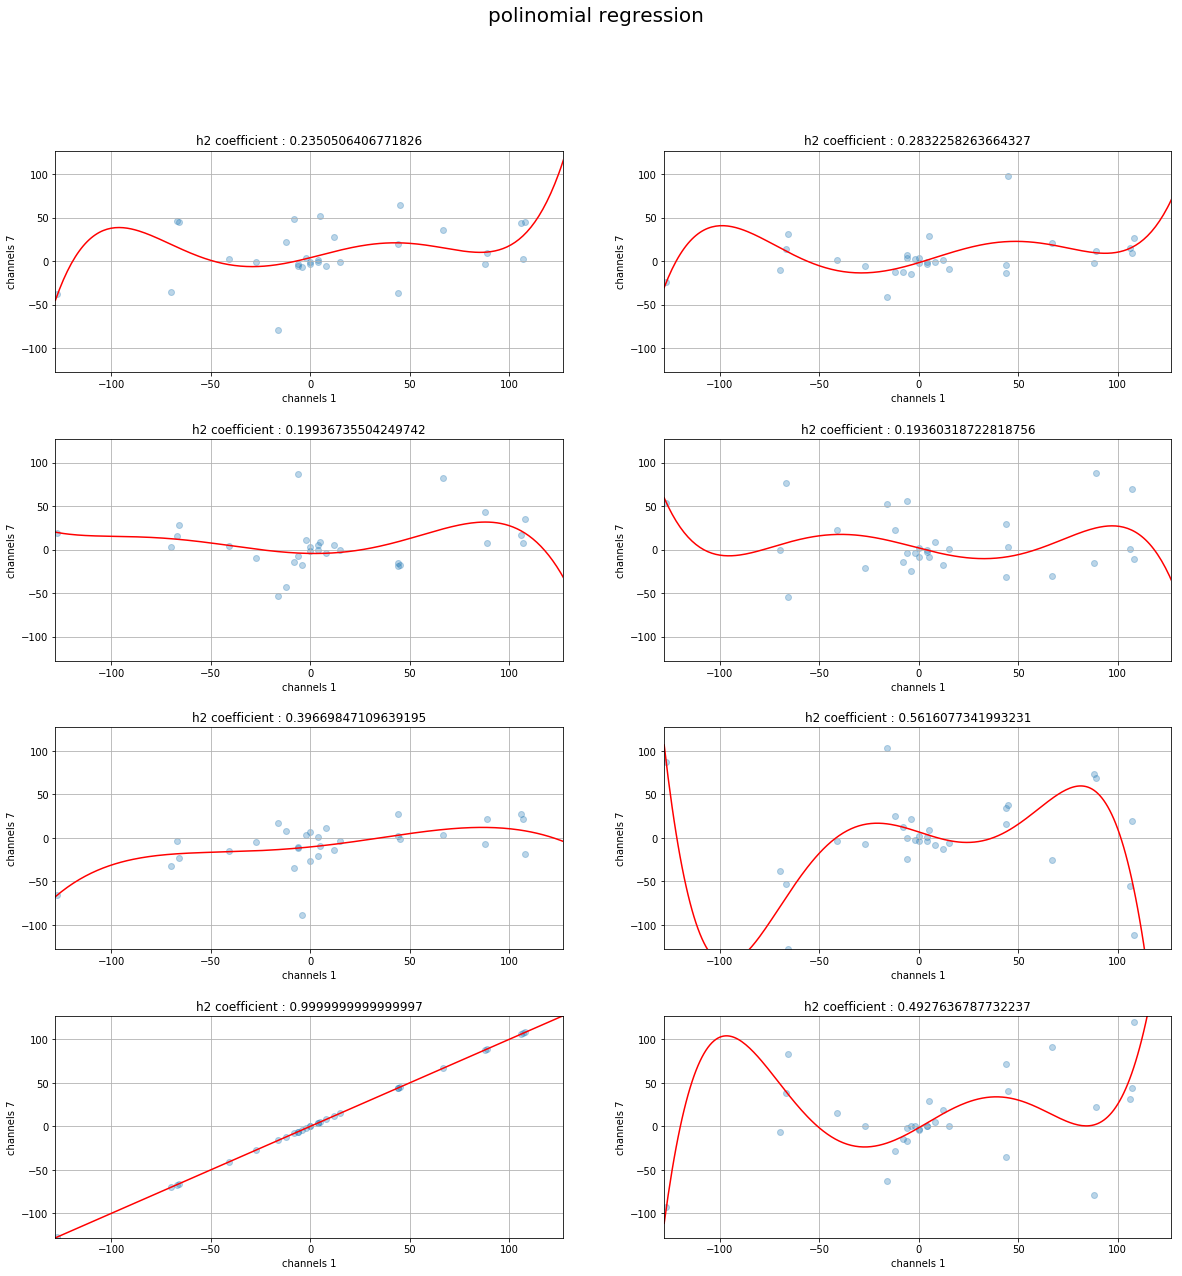

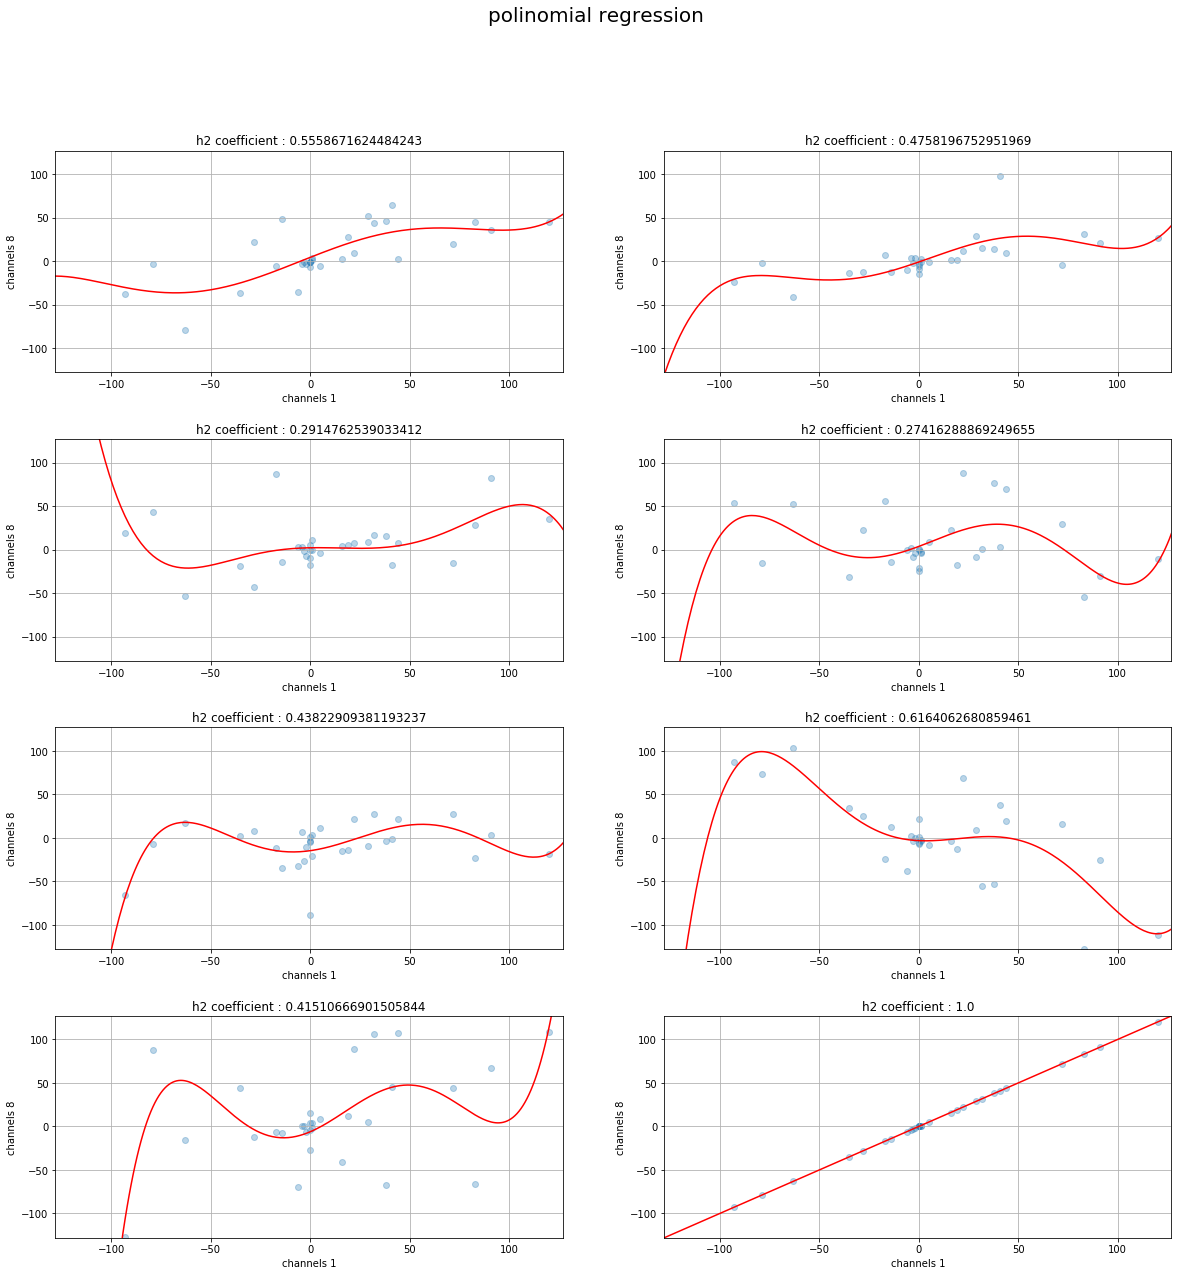

In [19]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy import interpolate

def polinomial(x: np.ndarray, y: np.ndarray, degree: int) :
    """
    https://stats.stackexchange.com/questions/365359/algorithms-to-model-non-linear-relationship-between-two-vectors
    """
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
    model.fit(x.reshape(-1, 1), y)

    return model

def piecewise_linear(x: np.ndarray, y: np.ndarray):
    """
    https://stats.stackexchange.com/questions/365359/algorithms-to-model-non-linear-relationship-between-two-vectors
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep
    """

    tck = interpolate.splrep(x, y, k=1, s=1, t = [35])

    return tck, interpolate.splev

def h2_coefficient(model, x: np.ndarray, y: np.ndarray):    
    
    y_mean = np.sum(y)/y.size
    power_y = np.sum(np.power(y, 2))
    model_y_sigma = np.sum(np.power(y - model.predict(x.reshape(-1, 1)), 2))
    coefficient = (power_y - model_y_sigma) / power_y
    
    return coefficient

seed = np.linspace(-128, 128, num=255, dtype=np.int)

for i in range(num_slicedEMG):
    if i == 2:
        break
        
    for j in range(sensor_channels):
        fig = plt.figure(figsize=(20,20))
        fig.suptitle("polinomial regression", fontsize=20)
        
        for k in range(sensor_channels):
            polinomial_model = polinomial(np.array(sEMGs[j][i]), np.array(sEMGs[k][i]), 5)
            h2 = h2_coefficient(polinomial_model, np.array(sEMGs[j][i]), np.array(sEMGs[k][i]))
            
            plt.subplot(4, 2, k+1)
            plt.scatter(sEMGs[j][i], sEMGs[k][i], alpha = .3, label = 'Data')
            plt.plot(seed, polinomial_model.predict(seed.reshape(-1, 1)), color='red', label = 'Model(Polinomial)')
            plt.xlabel("channels {}".format(1))
            plt.ylabel("channels {}".format(j+1))
            plt.xlim([-128, 127])
            plt.ylim([-128, 127])
            plt.title("h2 coefficient : {}".format(h2))
            plt.grid()
            plt.subplots_adjust(hspace=0.3)
            
        plt.show()

confusion_matrix = [[list() for i in range(sensor_channels)] for j in range(num_slicedEMG)]

for i in range(num_slicedEMG):
        
    for j in range(sensor_channels):
        for k in range(sensor_channels):
            polinomial_model = polinomial(np.array(sEMGs[j][i]), np.array(sEMGs[k][i]), 5)
            h2 = h2_coefficient(polinomial_model, np.array(sEMGs[j][i]), np.array(sEMGs[k][i]))
            confusion_matrix[i][j].append(h2)

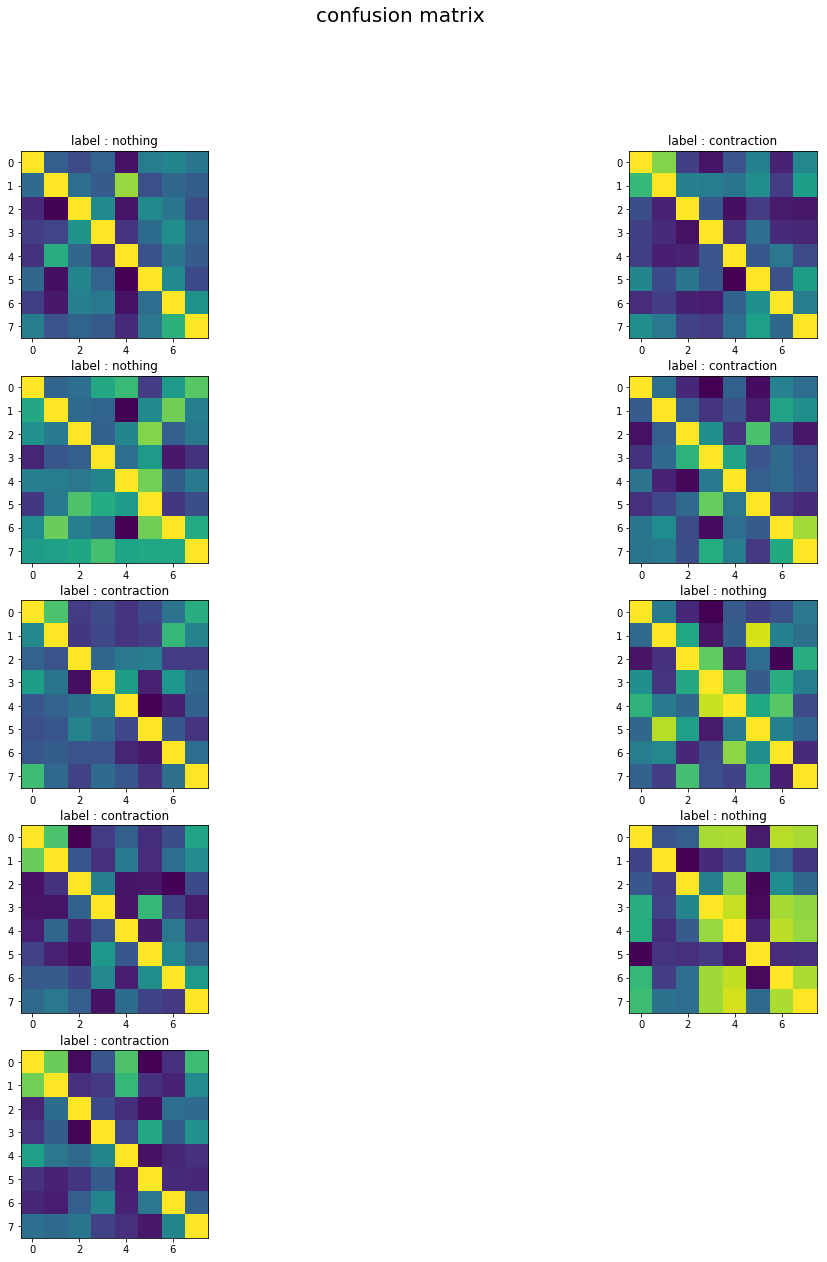

In [21]:
confusion_matrix = np.asarray(confusion_matrix)

fig = plt.figure(figsize=(20,20))
fig.suptitle("confusion matrix", fontsize=20)

for i in range(num_slicedEMG):
    image = confusion_matrix[i]
    
    args = "52" + str(i+1)
    ax1 = plt.subplot(5, 2, i+1)
    plt.title("label : {}".format("nothing" if yhats[j][i][0] == 0 else "contraction"))
    ax1.imshow(image)

plt.show()

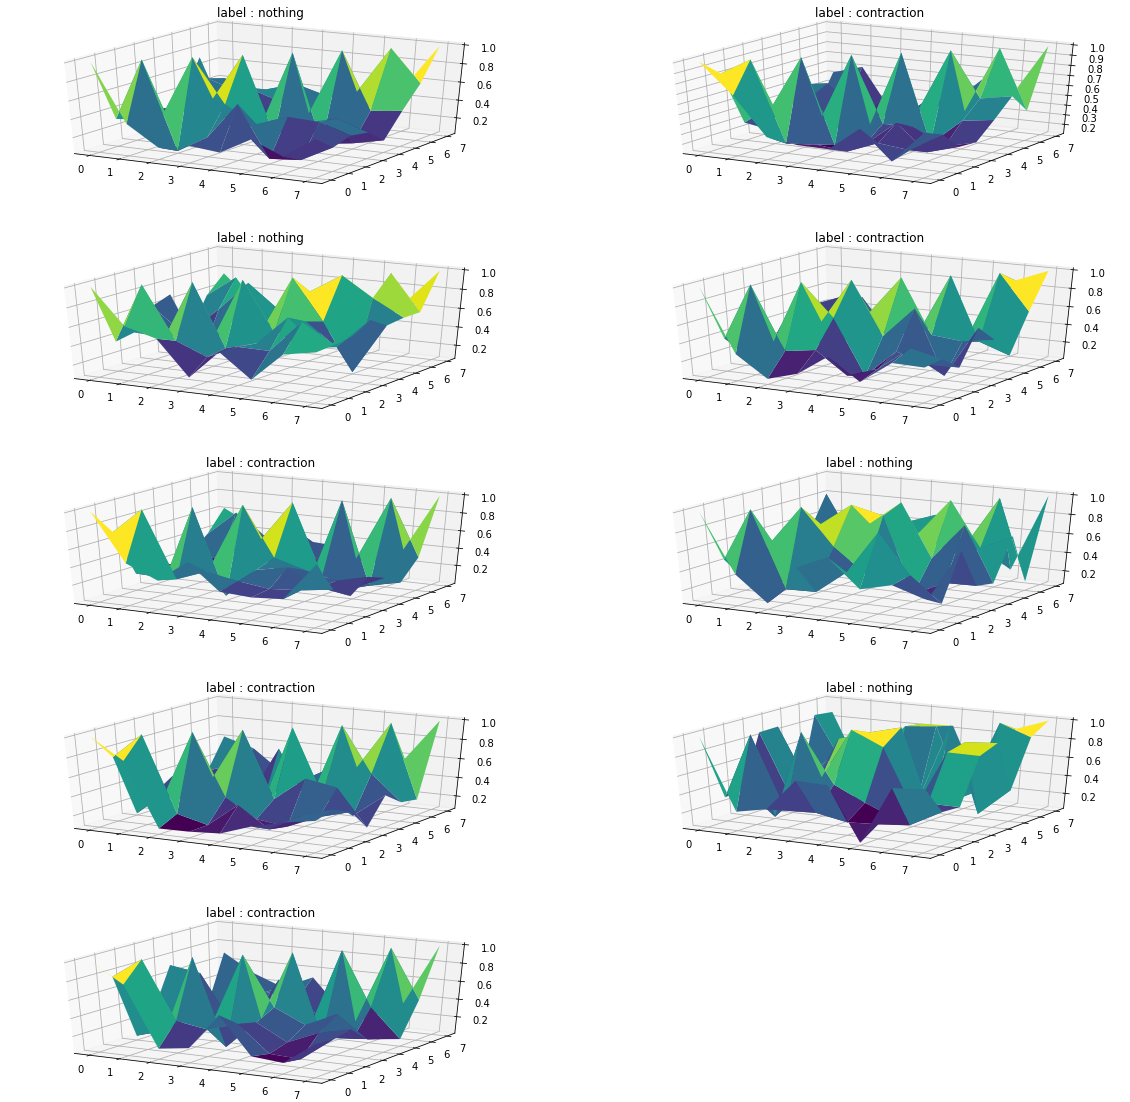

In [22]:
from mpl_toolkits import mplot3d

def confusion_func(x, y):
    
    result = [[list() for i in range(x.shape[0])] for j in range(y.shape[0])]
    
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            result[i][j].append(image[x[i][j]][y[i][j]])
            
    result = np.array(result).squeeze()
    
    return result

x = np.linspace(0, 7, num=8, dtype=np.int)
y = np.linspace(0, 7, num=8, dtype=np.int)


fig = plt.figure(figsize=(20,20))
for i in range(num_slicedEMG):
    image = confusion_matrix[i]
    
    X, Y = np.meshgrid(x, y)
    Z = confusion_func(X, Y)
    
    ax = fig.add_subplot(5, 2, (i+1), projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title("label : {}".format("nothing" if yhats[j][i][0] == 0 else "contraction"))
